## Importing libraries


In [57]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVR
import xgboost as xgb

import regex as re

from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

In [2]:
file_path = "..//datasets//final_final_adsorption_done_dataset.csv"
df = pd.read_csv(file_path)
df.shape
df.head()



,adsorbent,source_link,method_processing,surface_area_m2g,particle_size_mm,pore_volume_cm3g,pollutant,initial_concentration_mgL,temperature_c,contact_time_min,qe_mg_g,removal_percent,ph,dose_gL
0,RH-natural,"10.37885/221211191, Schneider et al., 2022","Washed, oven-dried 110°C/24h, milled, sieved 2...",2.545,0.212,0.003,Acidity,3680,17,360,14.93,25,NaN,61.61
1,RH-natural,"10.37885/221211191, Schneider et al., 2022","Washed, oven-dried 110°C/24h, milled, sieved 2...",2.545,0.212,0.003,Acidity,3680,23,360,11.94,20,NaN,61.61
2,RH-natural,"10.37885/221211191, Schneider et al., 2022","Washed, oven-dried 110°C/24h, milled, sieved 2...",2.545,0.212,0.003,Acidity,3680,17,360,6.57,11,NaN,61.61
3,RH-natural,"10.37885/221211191, Schneider et al., 2022","Washed, oven-dried 110°C/24h, milled, sieved 2...",2.545,0.212,0.003,Acidity,3680,20,360,14.33,24,NaN,78.34
4,RH-natural,"10.37885/221211191, Schneider et al., 2022","Washed, oven-dried 110°C/24h, milled, sieved 2...",2.545,0.212,0.003,Acidity,3680,17.5,420,10.72,40,NaN,137.97


## Handle Missing Data

In [3]:
# Create a copy of the dataframe to preserve the original
df_clean = df.copy()

# List of all observed placeholders for missing data
missing_values_list = ['N/P', 'N/A', 'N/A ', 'N/P ', 'N/A,N/A,N/A', 'N/A,N/A']

# Replace all placeholders with numpy.nan
for col in df_clean.columns:
    # Use.replace on the whole dataframe for efficiency
    df_clean.replace(missing_values_list, np.nan, inplace=True)
    # Also handle potential object columns where a value might be just whitespace
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].str.strip()
        df_clean.replace({col: r'^\s*$'}, np.nan, regex=True, inplace=True)

print("Missing values after standardization:")
display(df_clean.isnull().sum())
df_clean.isnull().sum().to_csv('1.csv')

Missing values after standardization:


adsorbent                      0
source_link                    0
method_processing              0
surface_area_m2g              33
particle_size_mm              42
pore_volume_cm3g              56
pollutant                      1
initial_concentration_mgL     16
temperature_c                 13
contact_time_min             125
qe_mg_g                        3
removal_percent              246
ph                            32
dose_gL                      189
dtype: int64

## Handling Ranges, Approximations and Text

In [4]:
# utilizing a function to handle these
def clean_numeric_column(series):
    """
    Cleans a pandas Series intended to be numeric.
    - Removes tilde '~' for approximations.
    - Calculates the mean of ranges (e.g., '10-20').
    - Converts to numeric, coercing errors to NaN.
    """
    # Convert to string to use string methods
    series_str = series.astype(str)
    
    # Remove tildes
    series_str = series_str.str.replace('~', '', regex=False)
    
    # Handle ranges by calculating the mean
    def parse_range(value):
        value = str(value)
        # Handle standard numeric ranges
        if '-' in value and value.replace('-', '', 1).replace('.', '', 2).isdigit():
            try:
                low, high = map(float, value.split('-'))
                return (low + high) / 2.0
            except ValueError:
                return np.nan
        # Handle specific text cases or return the value itself
        else:
            # Remove any non-numeric characters that are not part of a number (e.g., units)
            # This regex keeps numbers, decimals, and the negative sign
            cleaned_value = re.sub(r'[^\d.-]', '', value)
            return cleaned_value

    # Apply the range parsing function
    cleaned_series = series_str.apply(parse_range)
    
    # Convert to numeric, coercing any remaining non-numeric values to NaN
    return pd.to_numeric(cleaned_series, errors='coerce')

# List of columns to apply the numeric cleaning function
numeric_cols_to_clean = [
    'surface_area_m2g', 'particle_size_mm', 'pore_volume_cm3g',
    'initial_concentration_mgL', 'temperature_c', 'contact_time_min',
    'qe_mg_g', 'removal_percent', 'ph', 'dose_gL'
]

# Apply the function to each specified column
for col in numeric_cols_to_clean:
    df_clean[col] = clean_numeric_column(df_clean[col])

# Special handling for 'removal_percent' which had text like 'Increase'
df_clean.replace({'removal_percent': 'Increase'}, np.nan, inplace=True)
df_clean['removal_percent'] = pd.to_numeric(df_clean['removal_percent'], errors='coerce')

print("Data types after numeric cleaning:")
df_clean[numeric_cols_to_clean].info()

Data types after numeric cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   surface_area_m2g           292 non-null    float64
 1   particle_size_mm           283 non-null    float64
 2   pore_volume_cm3g           269 non-null    float64
 3   initial_concentration_mgL  303 non-null    float64
 4   temperature_c              312 non-null    float64
 5   contact_time_min           200 non-null    float64
 6   qe_mg_g                    322 non-null    float64
 7   removal_percent            79 non-null     float64
 8   ph                         293 non-null    float64
 9   dose_gL                    136 non-null    float64
dtypes: float64(10)
memory usage: 25.5 KB


In [5]:
print('Missing values after cleaning and standardizing')
df_clean.isnull().sum()

Missing values after cleaning and standardizing


adsorbent                      0
source_link                    0
method_processing              0
surface_area_m2g              33
particle_size_mm              42
pore_volume_cm3g              56
pollutant                      1
initial_concentration_mgL     22
temperature_c                 13
contact_time_min             125
qe_mg_g                        3
removal_percent              246
ph                            32
dose_gL                      189
dtype: int64

In [6]:
# List of categorical/text columns to standardize
text_cols_to_standardize = ['adsorbent', 'pollutant', 'method_processing']

for col in text_cols_to_standardize:
    # Ensure the column is treated as string type, handling potential NaNs
    df_clean[col] = df_clean[col].astype(str).str.lower().str.strip()
    # Replace the string 'nan' that resulted from the astype(str) conversion back to a real NaN
    df_clean.replace({col: 'nan'}, np.nan, inplace=True)

# Example of standardization
print("Sample of standardized 'adsorbent' names:")
print(df_clean['adsorbent'].unique()[:10])

Sample of standardized 'adsorbent' names:
['rh-natural' 'ac-commercial' 'cs-biochar' 'ch-biochar' 'ccac-150'
 'ccac-300' 'ccac-600' 'ccac-bh100' 'ccac-bh200' 'ccac-bh300']


## Feature Engineering with the method_processign column

In [7]:
def engineer_processing_features(df):
    """
    Extracts structured features from the 'method_processing' column.
    """
    df_eng = df.copy()
    
    # Ensure method_processing is a string to avoid errors with NaN
    proc_series = df_eng['method_processing'].fillna('')

    # 1. Pyrolysis/Carbonization Temperature
    # Looks for numbers followed by '°c' or 'c'
    df_eng['pyrolysis_temp_c'] = proc_series.str.extract(r'(\d{3,4})\s?°?c').astype(float)

    # 2. Activation Method and Agent
    # Define keywords for chemical and physical activation
    chemical_agents = {
        'koh': 'KOH', 'naoh': 'NaOH', 'h3po4': '$H_3PO_4$', 'hcl': 'HCl',
        'h2so4': '$H_2SO_4$', 'zncl2': '$ZnCl_2$', 'citric acid': 'Citric Acid'
    }
    
    df_eng['activation_agent'] = 'None'
    for agent_key, agent_name in chemical_agents.items():
        df_eng.loc[proc_series.str.contains(agent_key, na=False), 'activation_agent'] = agent_name
        
    df_eng['is_activated'] = np.where(df_eng['activation_agent']!= 'None', 1, 0)
    
    # 3. Modification Type
    df_eng['is_modified_acid'] = proc_series.str.contains(r'acid|hcl|h2so4|h3po4|hno3', na=False).astype(int)
    df_eng['is_modified_base'] = proc_series.str.contains(r'base|naoh|koh', na=False).astype(int)
    df_eng['is_raw_natural'] = proc_series.str.contains(r'raw|natural|unmodified|untreated', na=False).astype(int)

    return df_eng

df_featured = engineer_processing_features(df_clean)

print("Engineered features from 'method_processing':")
display(df_featured[['method_processing', 'pyrolysis_temp_c', 'activation_agent', 'is_activated', 'is_raw_natural']].sample(10))

Engineered features from 'method_processing':


,method_processing,pyrolysis_temp_c,activation_agent,is_activated,is_raw_natural
180,pyrolysis at 800°c,800.0,None,0,0
25,used black tea,NaN,None,0,0
81,pyrolysis at 500°c,500.0,None,0,0
124,pyrolysis at 450°c,450.0,None,0,0
99,pyrolysis at 450°c,450.0,None,0,0
104,pyrolysis at 450°c,450.0,None,0,0
109,pyrolysis at 450°c,450.0,None,0,0
120,pyrolysis at 450°c,450.0,None,0,0
168,pyrolysis at 800°c,800.0,None,0,0
321,pyrolysis at 700°c,700.0,None,0,0


## Hierachical structure for Adsorbent and pollutants

In [8]:
def create_hierarchical_features_refined(df):
    """
    Refines and creates hierarchical categories for adsorbents and pollutants
    using vectorized operations and an expanded keyword list to handle more edge cases.
    """
    df_hier = df.copy()

    # --- Pre-process source columns for robust matching ---
    # Convert to lowercase string and fill NaNs to prevent errors with.str accessor
    adsorbent_series = df_hier['adsorbent'].str.lower().fillna('')
    pollutant_series = df_hier['pollutant'].str.lower().fillna('')
    processing_series = df_hier['method_processing'].str.lower().fillna('')

    # --- Adsorbent Hierarchy (Expanded & Vectorized) ---
    
    # 1. Base Material - Expanded with new keywords from your inspection file
    material_conditions = [
        adsorbent_series.str.contains('rice|rh|oryza sativa|bran'),
        adsorbent_series.str.contains('coconut|cs'),
        adsorbent_series.str.contains('banana'),
        adsorbent_series.str.contains('corn|maize|cc|corncob'),
        adsorbent_series.str.contains('sugarcane|bagasse'),
        adsorbent_series.str.contains('orange|mandarin'),
        adsorbent_series.str.contains('tea'),
        adsorbent_series.str.contains('peanut|groundnut'),
        adsorbent_series.str.contains('wood|pine|sawdust'),
        adsorbent_series.str.contains('straw'),
        adsorbent_series.str.contains('almond'),
        adsorbent_series.str.contains('avocado'),
        adsorbent_series.str.contains('jackfruit'),
        adsorbent_series.str.contains('palm'),
        adsorbent_series.str.contains('sorghum'),
        adsorbent_series.str.contains('bamboo'),
        adsorbent_series.str.contains('tamarind|watermelon|beal|ambarella|peach|apricot|pomegranate|litchi|pomelo|grapefruit|mango|pistachio|cashew|date|olive'),
    ]
    material_choices = [
        'rice_based', 'coconut_based', 'banana_based', 'corn_based', 'sugarcane_based',
        'orange_peel', 'tea_waste', 'peanut_shell', 'wood_based', 'straw_based', 'almond_shell',
        'avocado_waste', 'jackfruit_waste', 'palm_waste', 'sorghum_waste', 'bamboo_based',
        'fruit_waste' # Grouping other rare fruit types
    ]
    df_hier['base_material'] = np.select(material_conditions, material_choices, default='other')

    # 2. Material Class - Using logical order to catch specific types first
    class_conditions = [
        adsorbent_series.str.contains('composite|coated'),
        adsorbent_series.str.contains('hydrochar'),
        adsorbent_series.str.contains('activated carbon|ac|activated charcoal'),
        adsorbent_series.str.contains('biochar|char'),
        df_hier['is_raw_natural'] == 1 # Assumes 'is_raw_natural' column exists
    ]
    class_choices = [
        'composite', 'hydrochar', 'activated_carbon', 'biochar', 'raw_biomass'
    ]
    df_hier['material_class'] = np.select(class_conditions, class_choices, default='unknown_class')

    # --- Pollutant Hierarchy (Expanded & Vectorized) ---
    pollutant_conditions = [
        pollutant_series.str.contains(r'pb|lead|cd|cadmium|cu|copper|zn|zinc|ni|nickel|cr|chromium|hg|mercury|as|arsenic|co|cobalt|mn|manganese|fe|iron'),
        pollutant_series.str.contains('dye|blue|red|violet|green|yellow|orange|ccr'),
        pollutant_series.str.contains('antibiotic|chloroquine|sertraline|carbamazepine|norfloxacin|tetracycline'),
        pollutant_series.str.contains('phenol'),
        pollutant_series.str.contains('nitrogen|nh4|phosphate|nutrient')
    ]
    pollutant_choices = [
        'heavy_metal', 'organic_dye', 'pharmaceutical', 'phenol', 'nutrient'
    ]
    df_hier['pollutant_class'] = np.select(pollutant_conditions, pollutant_choices, default='other_organic')
    
    # --- Feature Extraction from 'method_processing' ---
    # This is better than encoding the whole column. It creates meaningful binary features.
    df_hier['is_acid_treated'] = processing_series.str.contains('acid').astype(int)
    df_hier['is_base_treated'] = processing_series.str.contains('naoh|koh').astype(int)
    df_hier['is_chitosan_modified'] = processing_series.str.contains('chitosan').astype(int)

    return df_hier



# Apply the refined feature engineering function
df_featured_feat = create_hierarchical_features_refined(df_featured)


print("Hierarchical features for adsorbent and pollutant:")
display(df_featured_feat[['adsorbent', 'base_material', 'material_class', 'pollutant', 'pollutant_class']].sample(10))

# Check how many missing values are in the qe_mg_g column
missing_count = df_featured_feat['qe_mg_g'].isna().sum()
print(f"Number of rows with missing qe_mg_g values: {missing_count}")

# Drop rows where qe_mg_g is missing
df = df_featured_feat.dropna(subset=['qe_mg_g'])

# Verify the rows were dropped
print(f"Shape of dataframe after dropping rows: {df.shape}")

# Drop the original high-cardinality and metadata columns
# This is the key to preventing the warning. encode the NEW columns, not the old ones.
columns_to_drop = ['adsorbent', 'pollutant', 'method_processing', 'source_link', 'removal_percent']
df_model_input = df.drop(columns=columns_to_drop)

# check shape after dropping the columns
print(f"Shape of dataframe after dropping rows: {df_model_input.shape}")


# df_model_input.isnull().sum()

Hierarchical features for adsorbent and pollutant:


,adsorbent,base_material,material_class,pollutant,pollutant_class
45,bac,other,activated_carbon,ammoniacal nitrogen,heavy_metal
301,sac,other,activated_carbon,methylene blue (mb),organic_dye
24,stl-mb,other,raw_biomass,methylene blue,organic_dye
132,ac900,other,activated_carbon,methylene blue (mb),organic_dye
223,cs-ac,coconut_based,activated_carbon,gr,other_organic
178,cmcac,other,activated_carbon,congo red (cr),heavy_metal
211,sac,other,activated_carbon,methylene blue (mb),organic_dye
103,ac700,other,activated_carbon,methylene blue (mb),organic_dye
138,cmcac,other,activated_carbon,methyl violet (mv),organic_dye
15,ccac-150,corn_based,activated_carbon,oil & grease,heavy_metal


Number of rows with missing qe_mg_g values: 3
Shape of dataframe after dropping rows: (322, 26)
Shape of dataframe after dropping rows: (322, 21)


surface_area_m2g              32
particle_size_mm              39
pore_volume_cm3g              54
initial_concentration_mgL     19
temperature_c                 10
contact_time_min             122
qe_mg_g                        0
ph                            29
dose_gL                      186
pyrolysis_temp_c              41
activation_agent               0
is_activated                   0
is_modified_acid               0
is_modified_base               0
is_raw_natural                 0
base_material                  0
material_class                 0
pollutant_class                0
is_acid_treated                0
is_base_treated                0
is_chitosan_modified           0
dtype: int64

# Separate features and target variables

In [9]:
# Separate Features (X) and the Target Variable (y) ---

X = df_model_input.drop(columns=['qe_mg_g'])

# setting 'qe_mg_g' as primary target
y = df_model_input['qe_mg_g']








# STRATIFIED SPLITTING OF DATASET

In [10]:
# Stratify by Binned Target Variable (Recommended for Regression) ---

print("\n\n--- Stratifying by Binned Target Variable ('qe_mg_g') ---")

# Create bins from the continuous target variable 'y'
# use pd.cut to create 5 bins of equal frequency (quintiles) using qcut.
# This is to ensures each bin has roughly the same number of data points.
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')


# Perform the stratified split using these new bins
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y_binned, # Stratify based on the binned target
    random_state=42
)

# --- Verification Step ---
# Check the distribution of the bins
print("Original binned target distribution (%):")
print(round(y_binned.value_counts(normalize=True) * 100, 2))

# We need to create bins for y_train and y_test to verify
y_train_binned = pd.qcut(y_train, q=5, labels=False, duplicates='drop')
y_test_binned = pd.qcut(y_test, q=5, labels=False, duplicates='drop')

print("\nTraining set binned target distribution (%):")
print(round(y_train_binned.value_counts(normalize=True) * 100, 2))

print("\nTest set binned target distribution (%):")
print(round(y_test_binned.value_counts(normalize=True) * 100, 2))



--- Stratifying by Binned Target Variable ('qe_mg_g') ---
Original binned target distribution (%):
qe_mg_g
0    20.19
4    20.19
1    19.88
2    19.88
3    19.88
Name: proportion, dtype: float64

Training set binned target distribution (%):
qe_mg_g
4    20.23
0    20.23
2    19.84
1    19.84
3    19.84
Name: proportion, dtype: float64

Test set binned target distribution (%):
qe_mg_g
0    20.0
4    20.0
2    20.0
3    20.0
1    20.0
Name: proportion, dtype: float64


# Imputation

In [11]:
impute_by_group_cols = ['surface_area_m2g', 'pore_volume_cm3g', 'pyrolysis_temp_c']
# Calculate the median for each 'material_class' from the TRAINING data ONLY.

for col in impute_by_group_cols:
    median_map = X_train.groupby('material_class')[col].median()

    # Use this map to fill missing values in BOTH the training and test sets.
    X_train[col] = X_train[col].fillna(X_train['material_class'].map(median_map))
    X_test[col] = X_test[col].fillna(X_test['material_class'].map(median_map))
    # Handle a potential edge case: If a material_class exists in the test set 
    # but not in the training set, its median will be NaN. We fill these with the global median from the training set.
    glob_median = X_train[col].median()
    X_test.fillna({col: glob_median}, inplace=True)

# After the group-based imputation loop
for col in impute_by_group_cols:
    # Apply global median to any remaining NaNs in both datasets
    glob_median = X_train[col].median()
    X_train.fillna({col: glob_median}, inplace=True)
    X_test.fillna({col: glob_median}, inplace=True)



# --- Global Median Imputation ---
# For columns where a global median is more appropriate
# for temperature, ph
impute_globally_cols = [
    'particle_size_mm', 'initial_concentration_mgL', 'temperature_c',
    'contact_time_min', 'ph', 'dose_gL'
]

for col in impute_globally_cols:
    global_median = X_train[col].median()
    X_train.fillna({col: global_median}, inplace=True)
    X_test.fillna({col: global_median}, inplace=True)


# X_train.isnull().sum()


surface_area_m2g             0
particle_size_mm             0
pore_volume_cm3g             0
initial_concentration_mgL    0
temperature_c                0
contact_time_min             0
ph                           0
dose_gL                      0
pyrolysis_temp_c             0
activation_agent             0
is_activated                 0
is_modified_acid             0
is_modified_base             0
is_raw_natural               0
base_material                0
material_class               0
pollutant_class              0
is_acid_treated              0
is_base_treated              0
is_chitosan_modified         0
dtype: int64

## Exploratory Data Analysis

In [12]:
# prepare dataset for analysis
df_eda = pd.concat([X_train, y_train], axis=1)

In [13]:
df_eda['qe_mg_g'].max()

2239.0

## Distribution of the Target Variable: Adsorption Capacity (qe_mg_g)

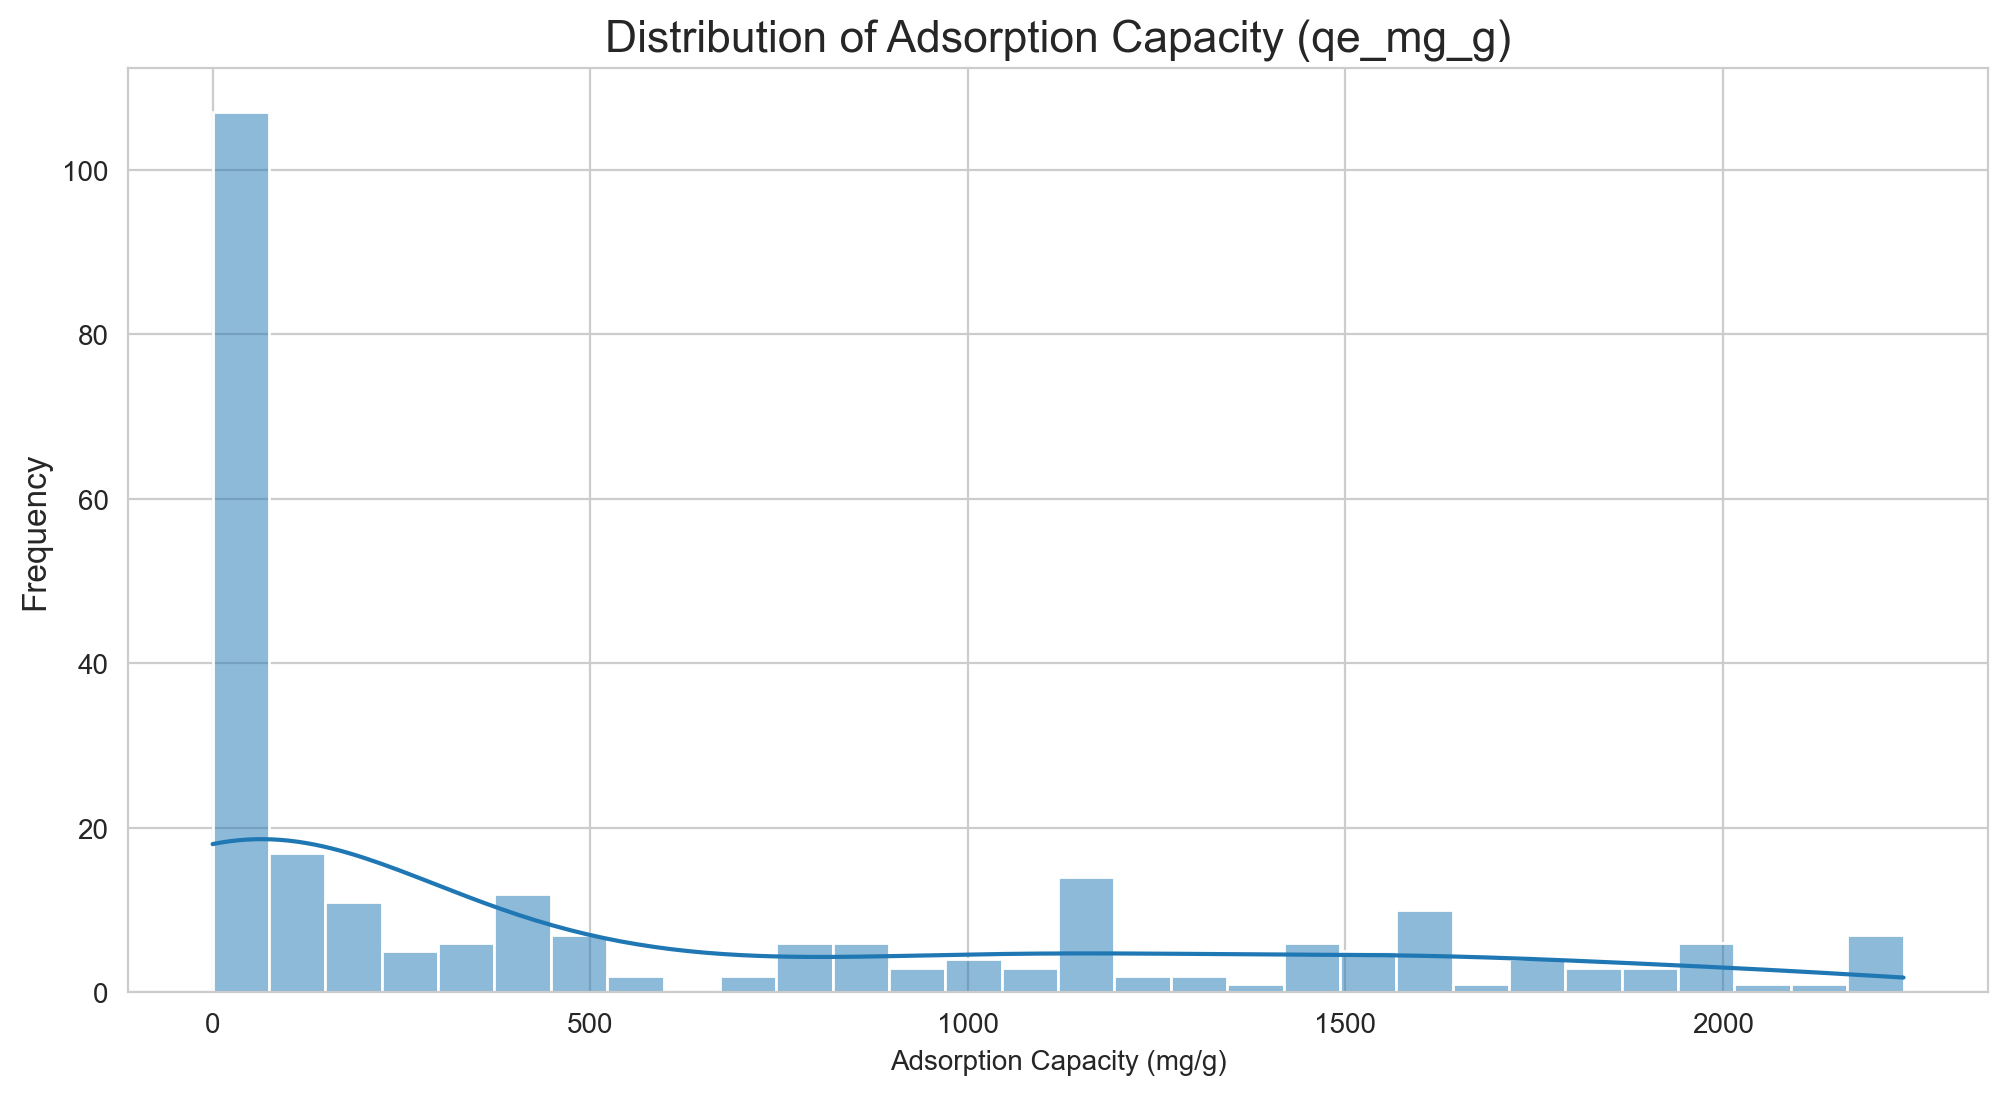

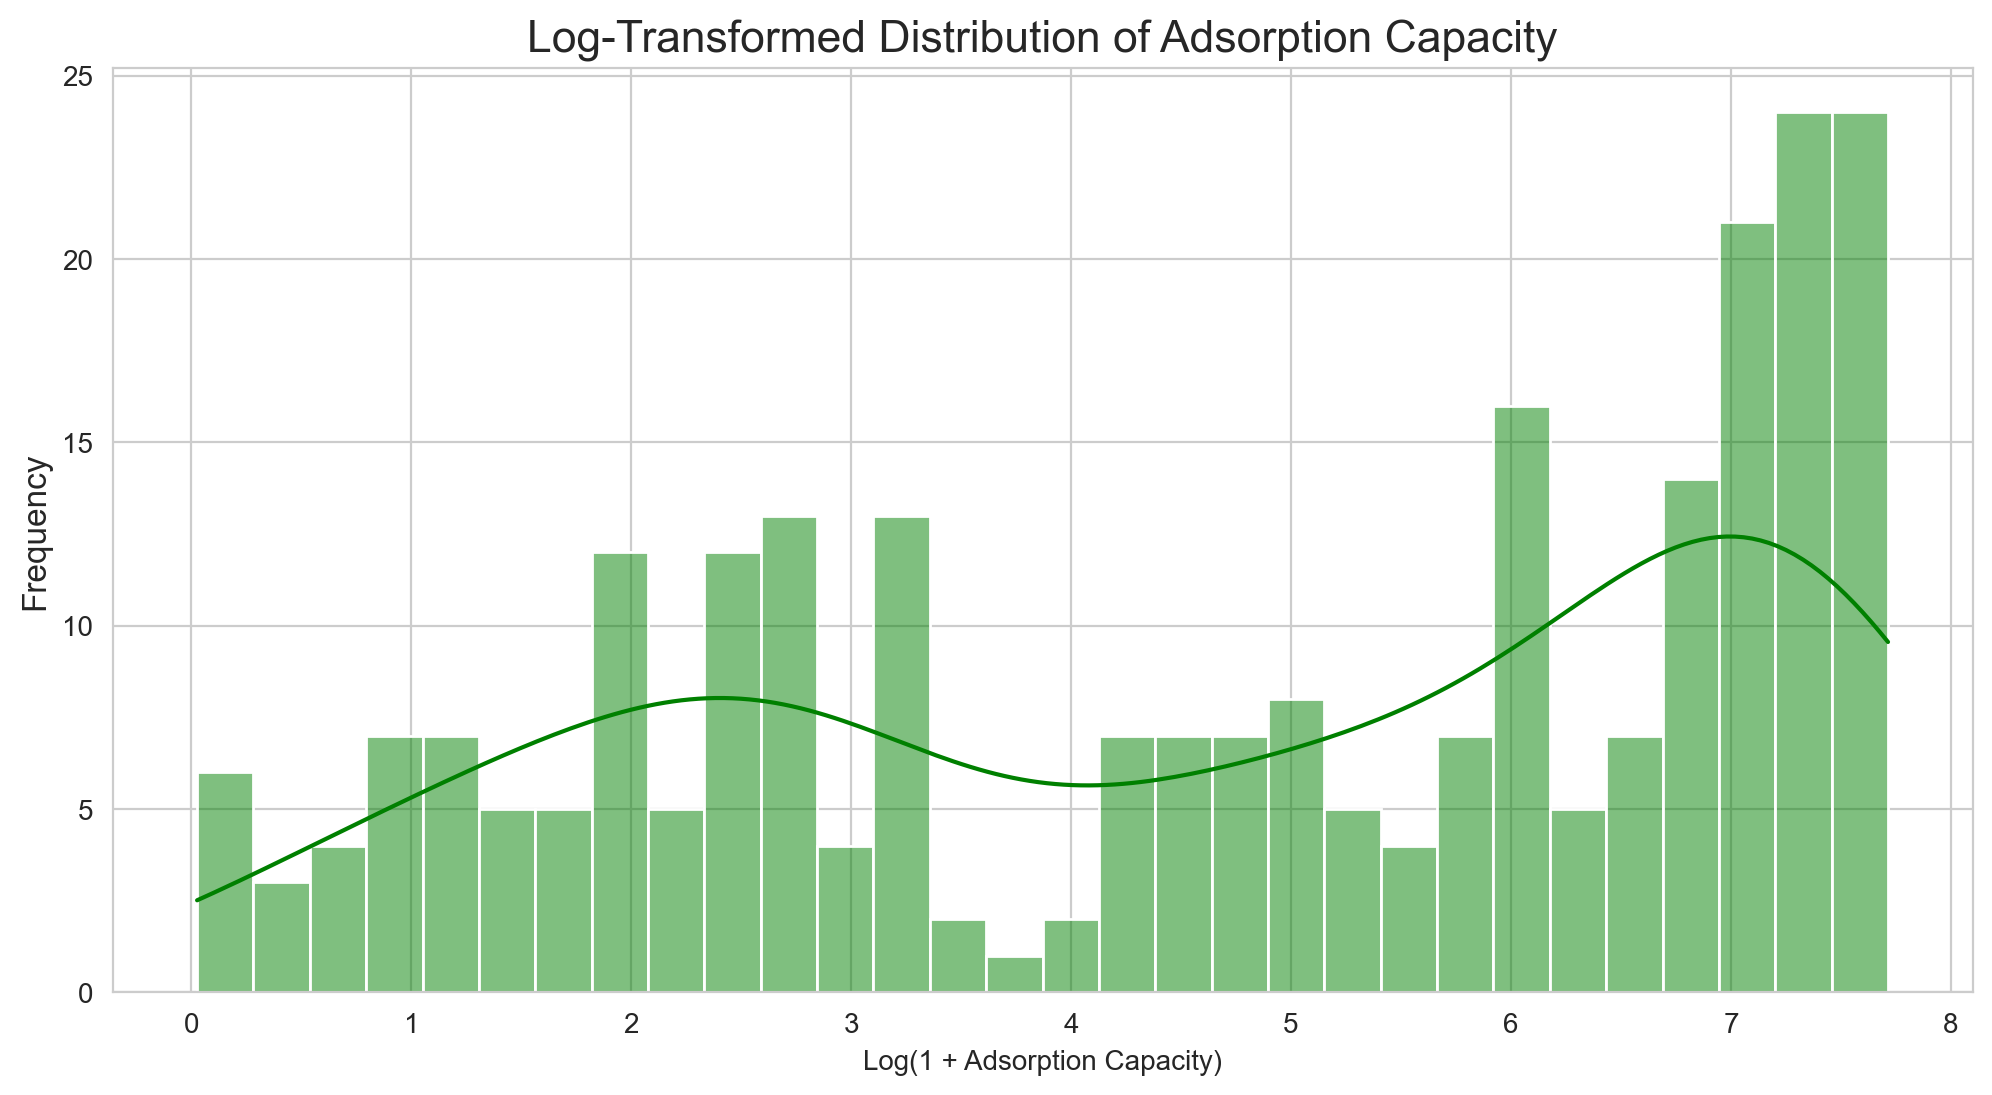

In [14]:
# set style for plots
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(df_eda['qe_mg_g'], kde=True, bins=30)
plt.title('Distribution of Adsorption Capacity (qe_mg_g)', fontsize=16)
plt.xlabel('Adsorption Capacity (mg/g)')
plt.ylabel('Frequency', fontsize=12)

# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plot2.png', dpi=500)  

plt.show()

# For better visualization of skewed data, a log transform is often useful
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(df_eda['qe_mg_g']), kde=True, bins=30, color='green')
plt.title('Log-Transformed Distribution of Adsorption Capacity', fontsize=16)
plt.xlabel('Log(1 + Adsorption Capacity)')
plt.ylabel('Frequency', fontsize=12)

# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plot.png', dpi=500)  


plt.show()

## Frequency of adsorbent and pollutant class

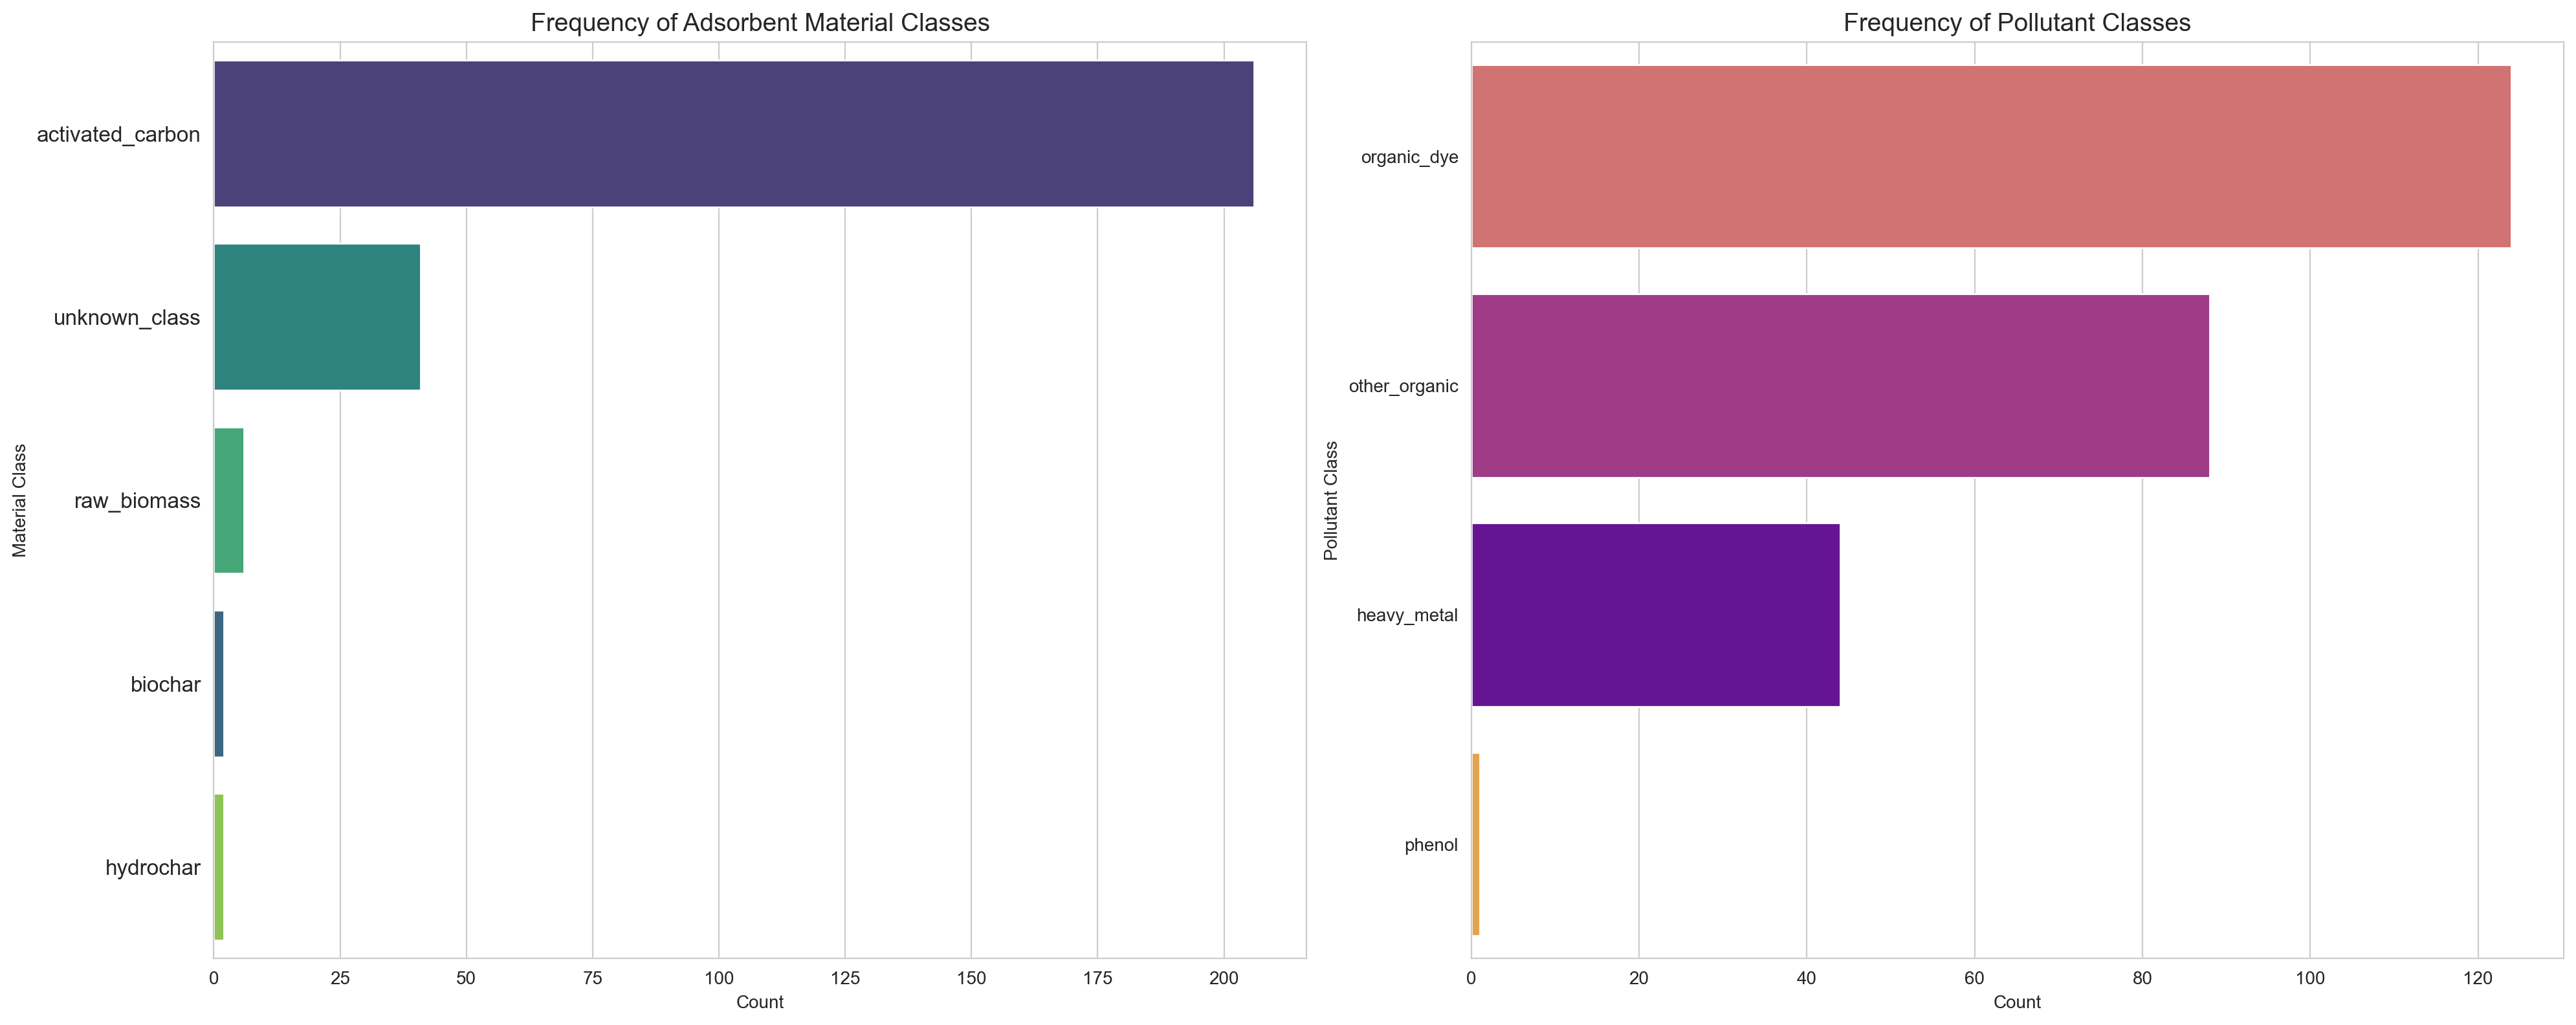

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.set_style("whitegrid")

# Plot for Material Class
# sns.countplot(y='material_class', data=df_eda, order=df_eda['material_class'].value_counts().index, ax=axes[0], palette='viridis')
sns.countplot(y='material_class', hue='material_class', data=df_eda, order=df_eda['material_class'].value_counts().index, 
              ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('Frequency of Adsorbent Material Classes', fontsize=14)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Material Class', fontsize=10)
axes[0].tick_params(axis='y', labelsize=12)  # Increased y-axis tick label size

# Plot for Pollutant Class
sns.countplot(y='pollutant_class', hue='pollutant_class', data=df_eda, order=df_eda['pollutant_class'].value_counts().index, 
                ax=axes[1], palette='plasma', legend=False)
axes[1].set_title('Frequency of Pollutant Classes', fontsize=14)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Pollutant Class', fontsize=10)
axes[0].tick_params(axis='y', labelsize=12)  # Increased y-axis tick label size


# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plot2.png', dpi=500)  

plt.tight_layout()
plt.show()

## Scatter Plots

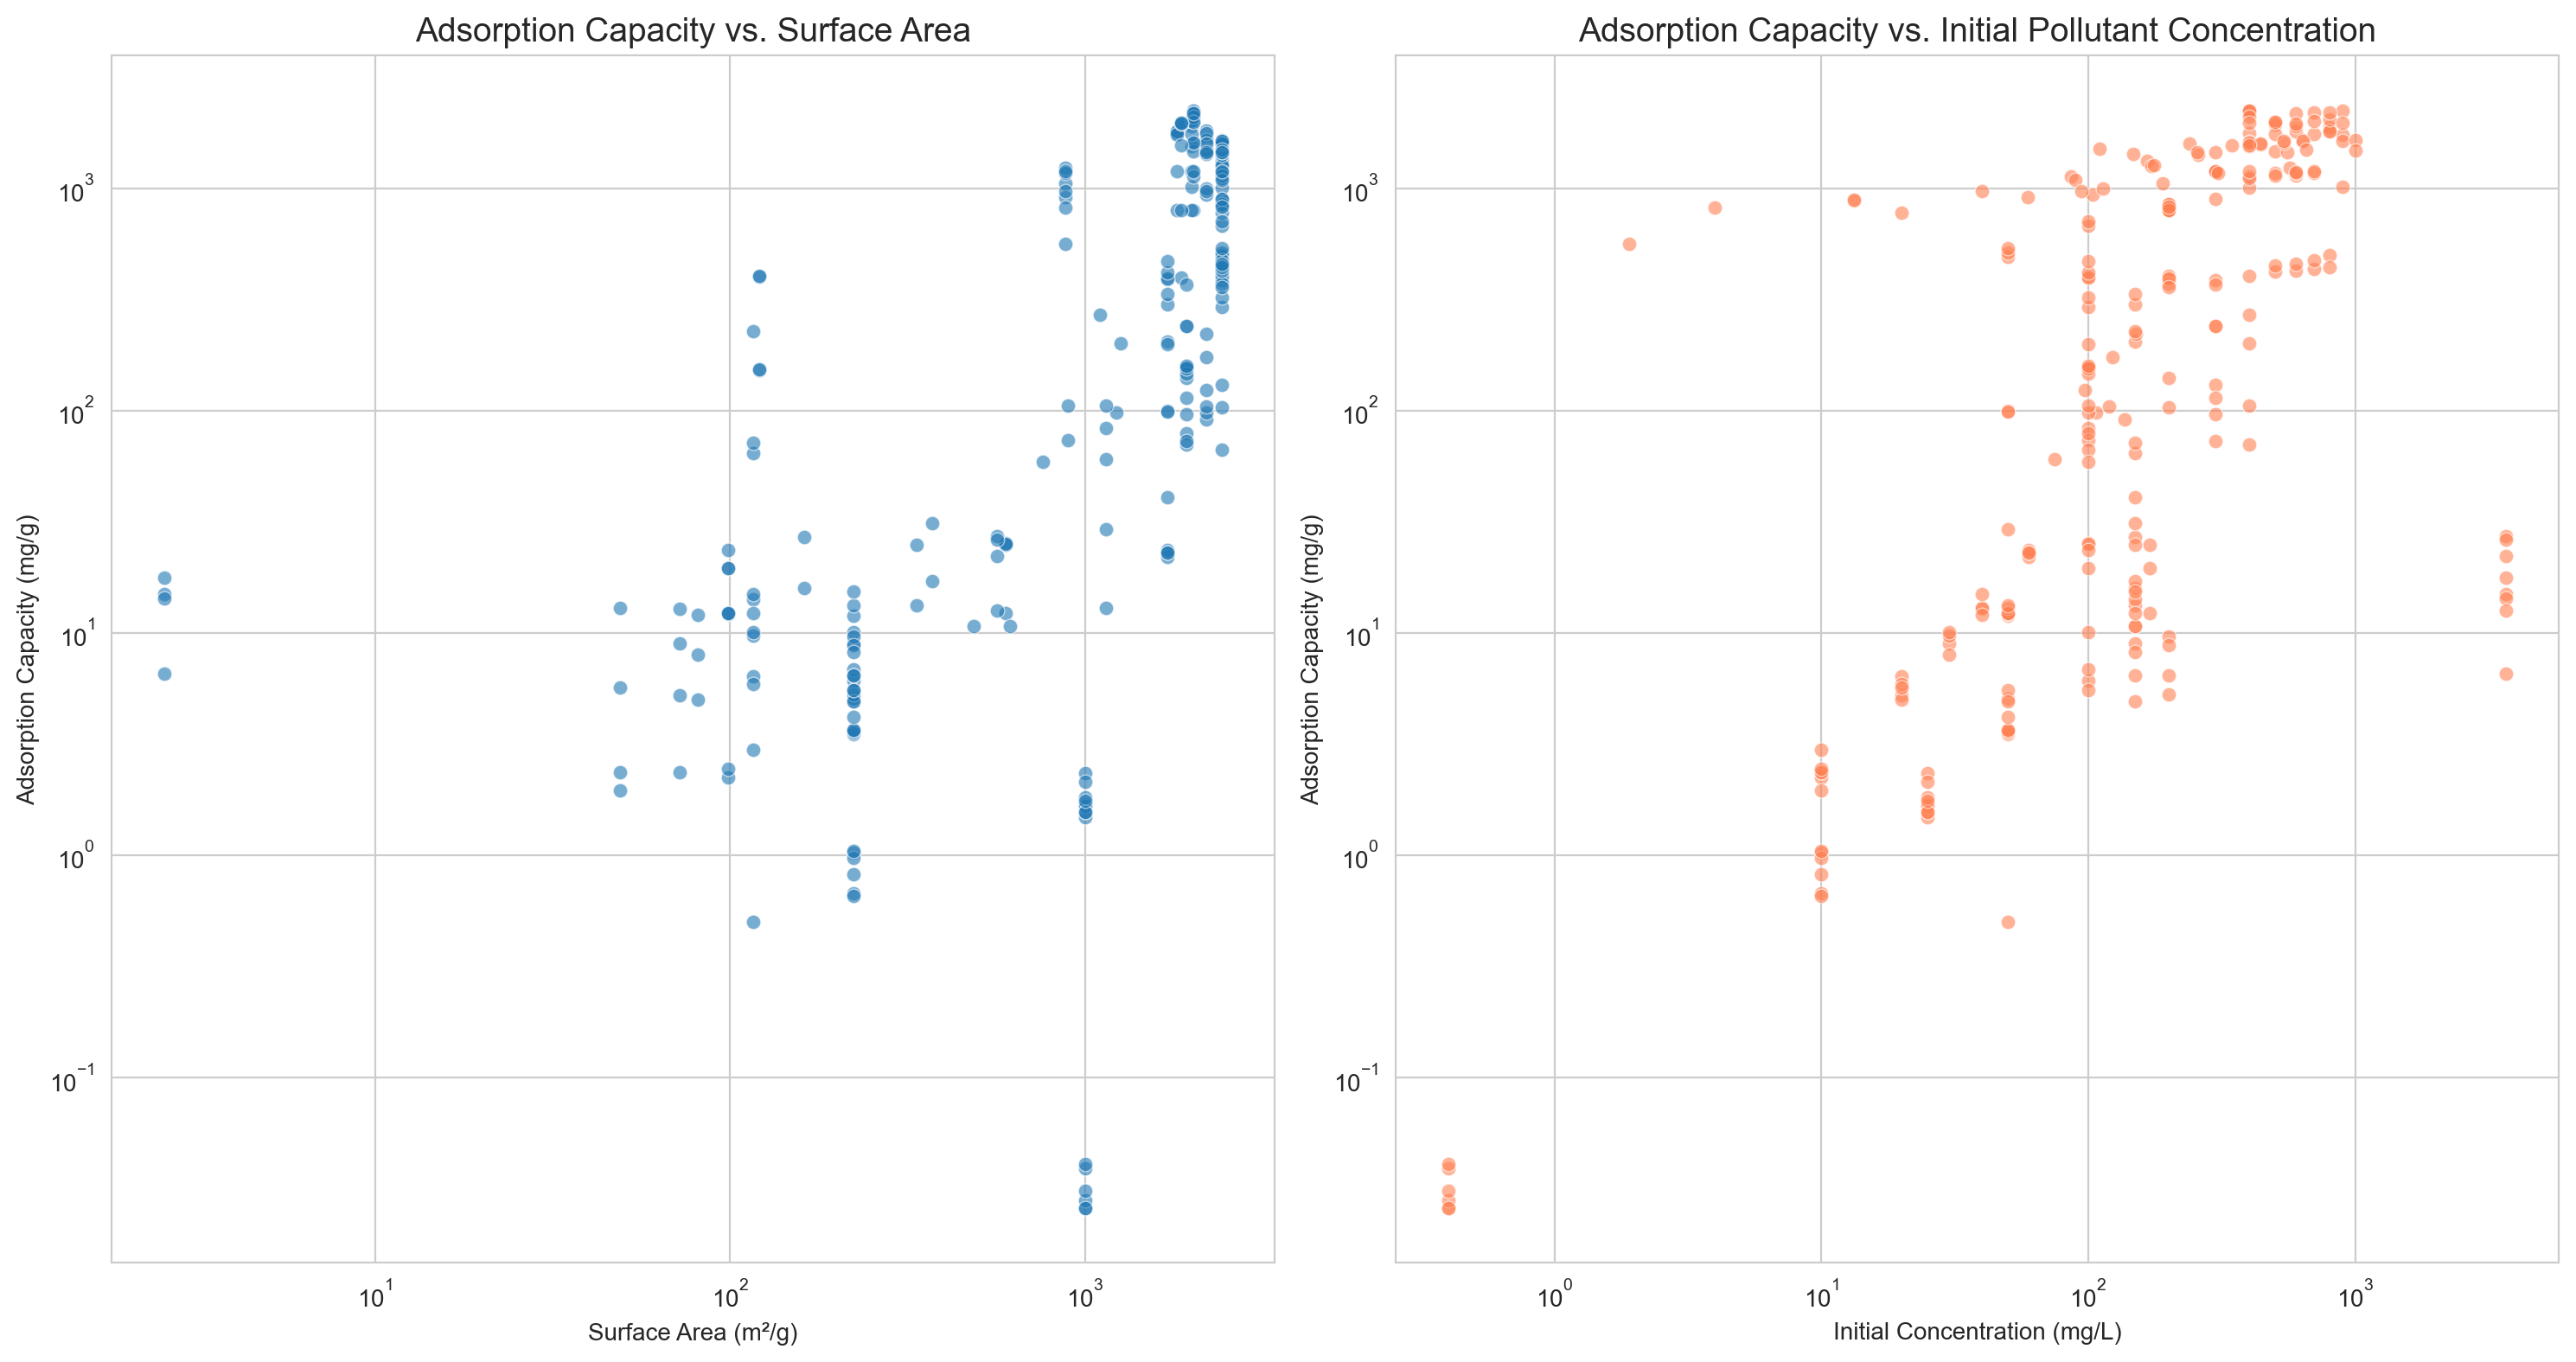

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.set_style("whitegrid")

# Surface Area vs. Adsorption Capacity
sns.scatterplot(x='surface_area_m2g', y='qe_mg_g', data=df_eda, alpha=0.6, ax=axes[0])
axes[0].set_title('Adsorption Capacity vs. Surface Area', fontsize=14)
axes[0].set_xlabel('Surface Area (m²/g)')
axes[0].set_ylabel('Adsorption Capacity (mg/g)')
axes[0].set_xscale('log') # Use log scale for better visualization of wide-ranging data
axes[0].set_yscale('log')

# Initial Concentration vs. Adsorption Capacity
sns.scatterplot(x='initial_concentration_mgL', y='qe_mg_g', data=df_eda, alpha=0.6, ax=axes[1], color='coral')
axes[1].set_title('Adsorption Capacity vs. Initial Pollutant Concentration', fontsize=14)
axes[1].set_xlabel('Initial Concentration (mg/L)')
axes[1].set_ylabel('Adsorption Capacity (mg/g)')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

plt.tight_layout()


# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plot2.png', dpi=500)  


plt.show()

## Box plots

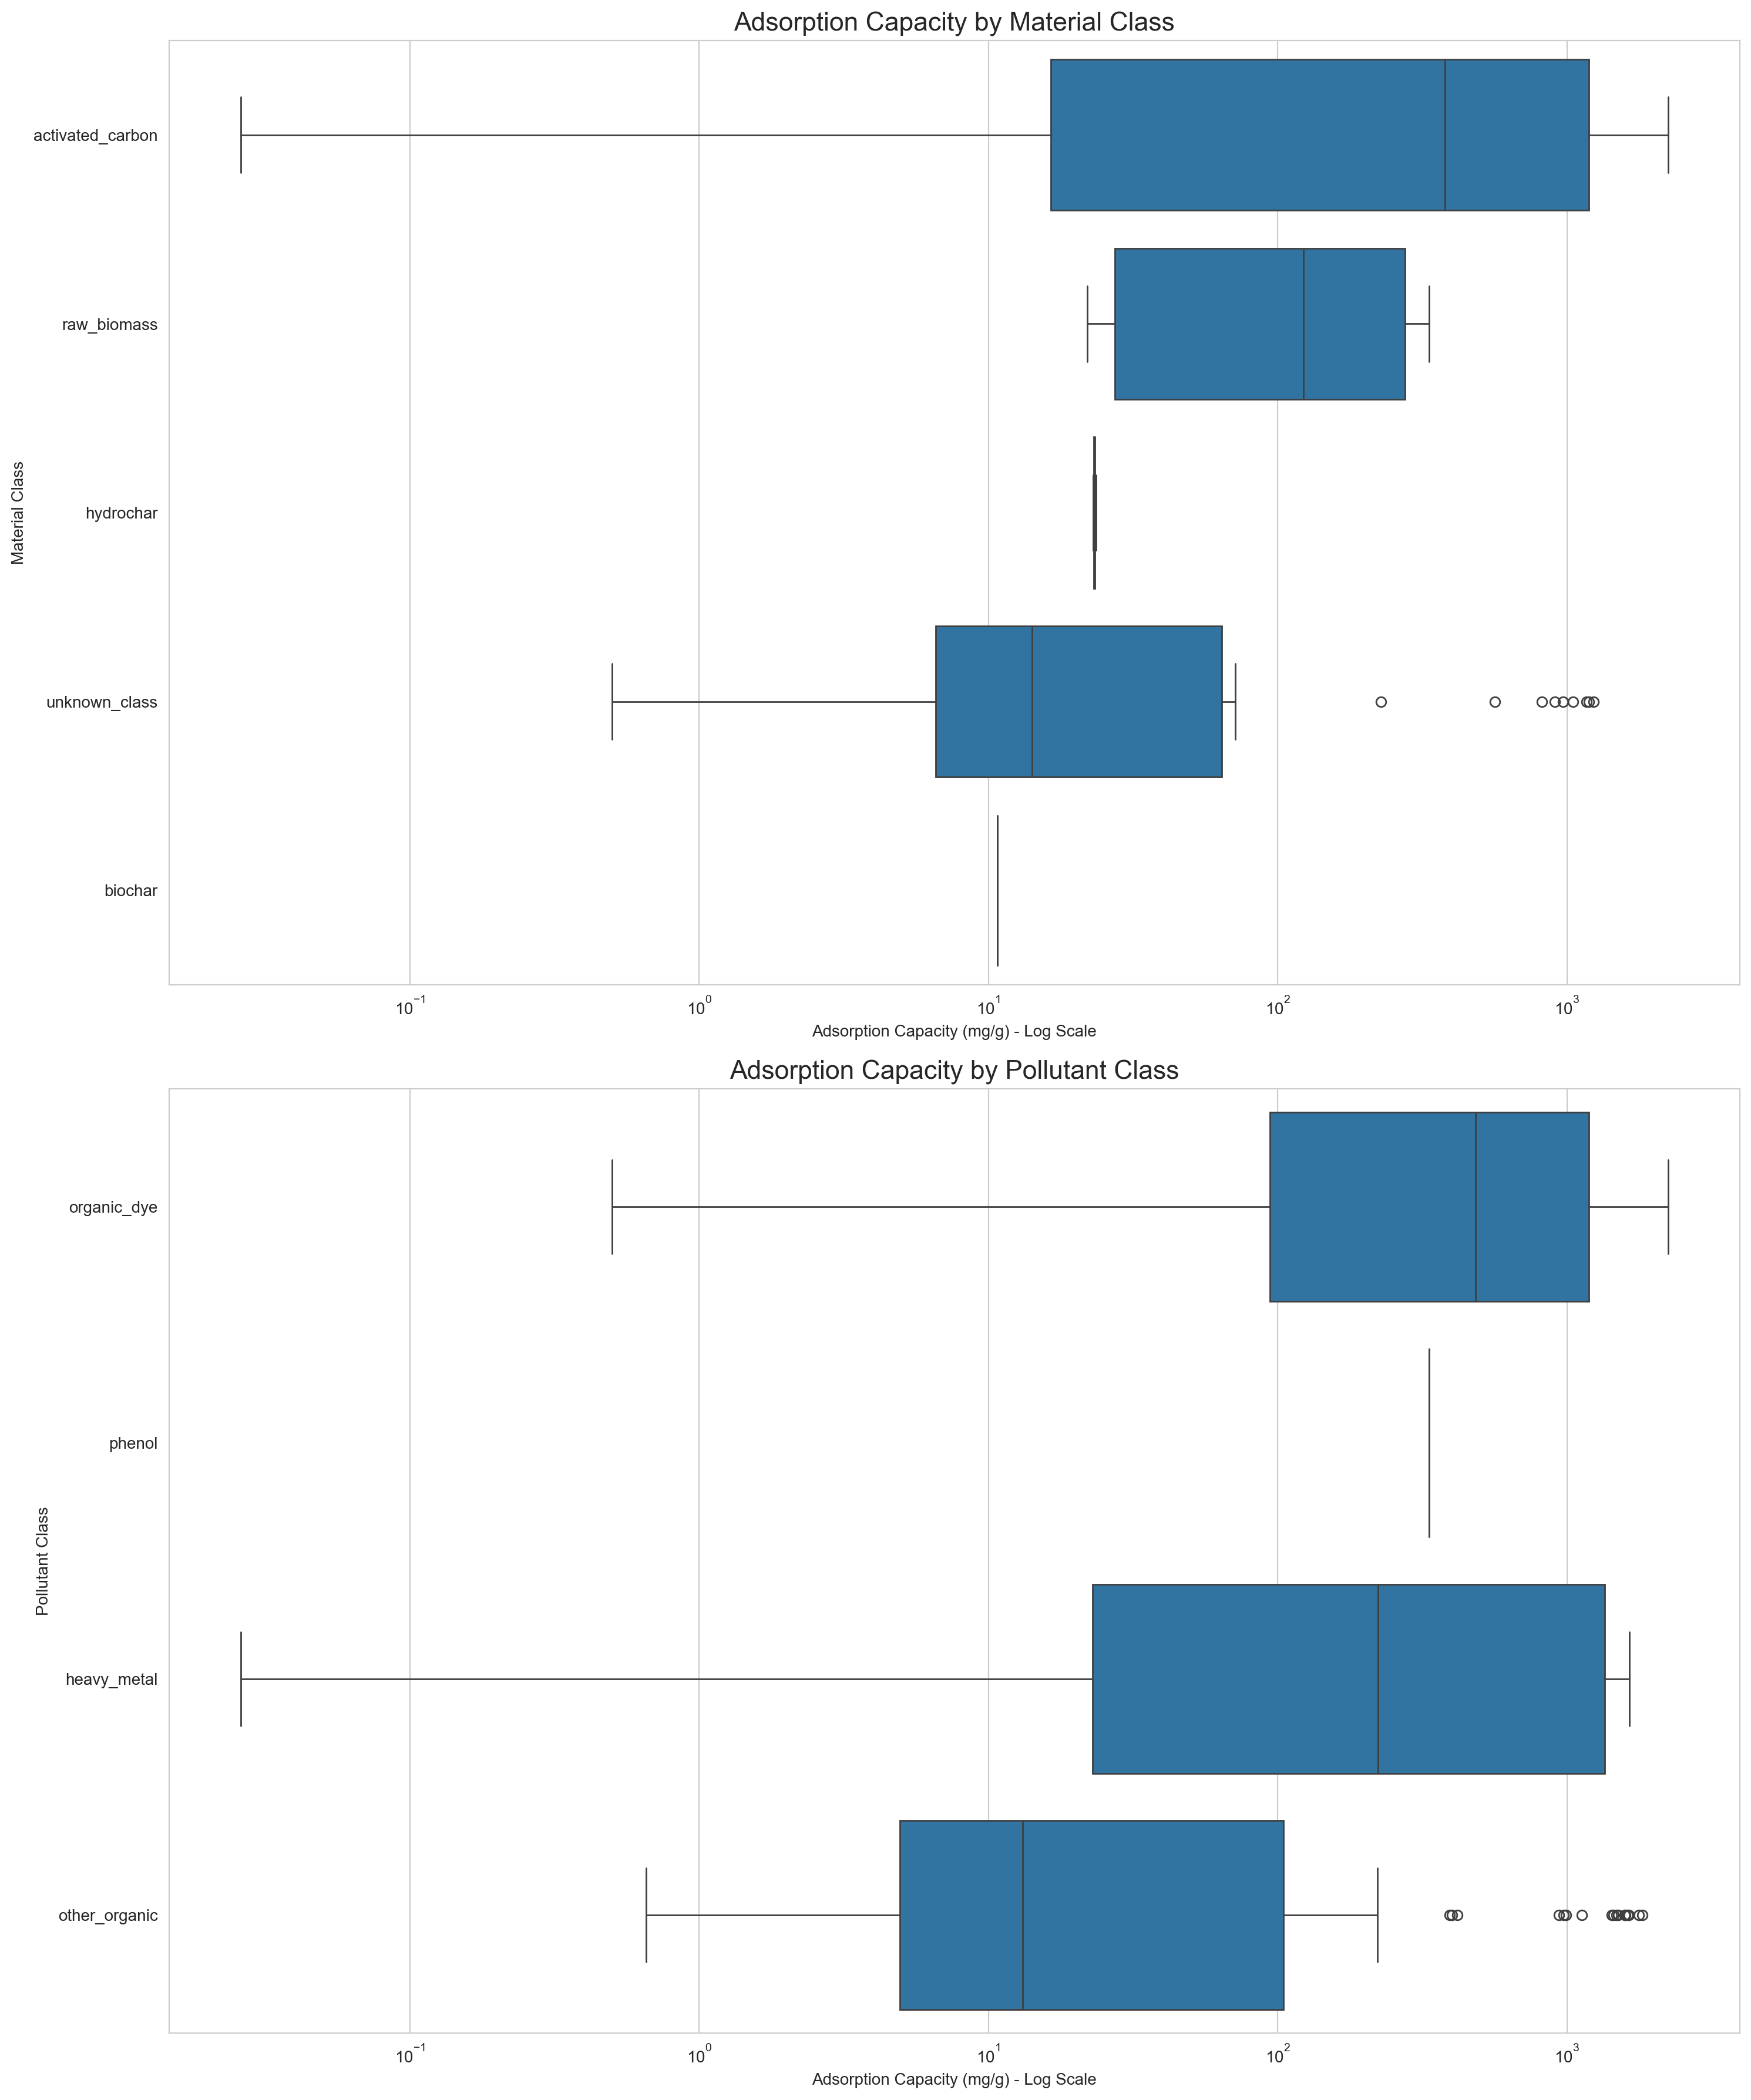

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(15, 18))
sns.set_style("whitegrid")

# Boxplot for Material Class
sns.boxplot(x='qe_mg_g', y='material_class', data=df_eda, ax=axes[0],
            order=df_eda.groupby('material_class')['qe_mg_g'].median().sort_values(ascending=False).index)
axes[0].set_title('Adsorption Capacity by Material Class', fontsize=16)
axes[0].set_xlabel('Adsorption Capacity (mg/g) - Log Scale')
axes[0].set_ylabel('Material Class')
axes[0].set_xscale('log')

# Boxplot for Pollutant Class
sns.boxplot(x='qe_mg_g', y='pollutant_class', data=df_eda, ax=axes[1],
            order=df_eda.groupby('pollutant_class')['qe_mg_g'].median().sort_values(ascending=False).index)
axes[1].set_title('Adsorption Capacity by Pollutant Class', fontsize=16)
axes[1].set_xlabel('Adsorption Capacity (mg/g) - Log Scale')
axes[1].set_ylabel('Pollutant Class')
axes[1].set_xscale('log')

plt.tight_layout()

# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plot2.png', dpi=500)

plt.show()

## Correlation Heatmap

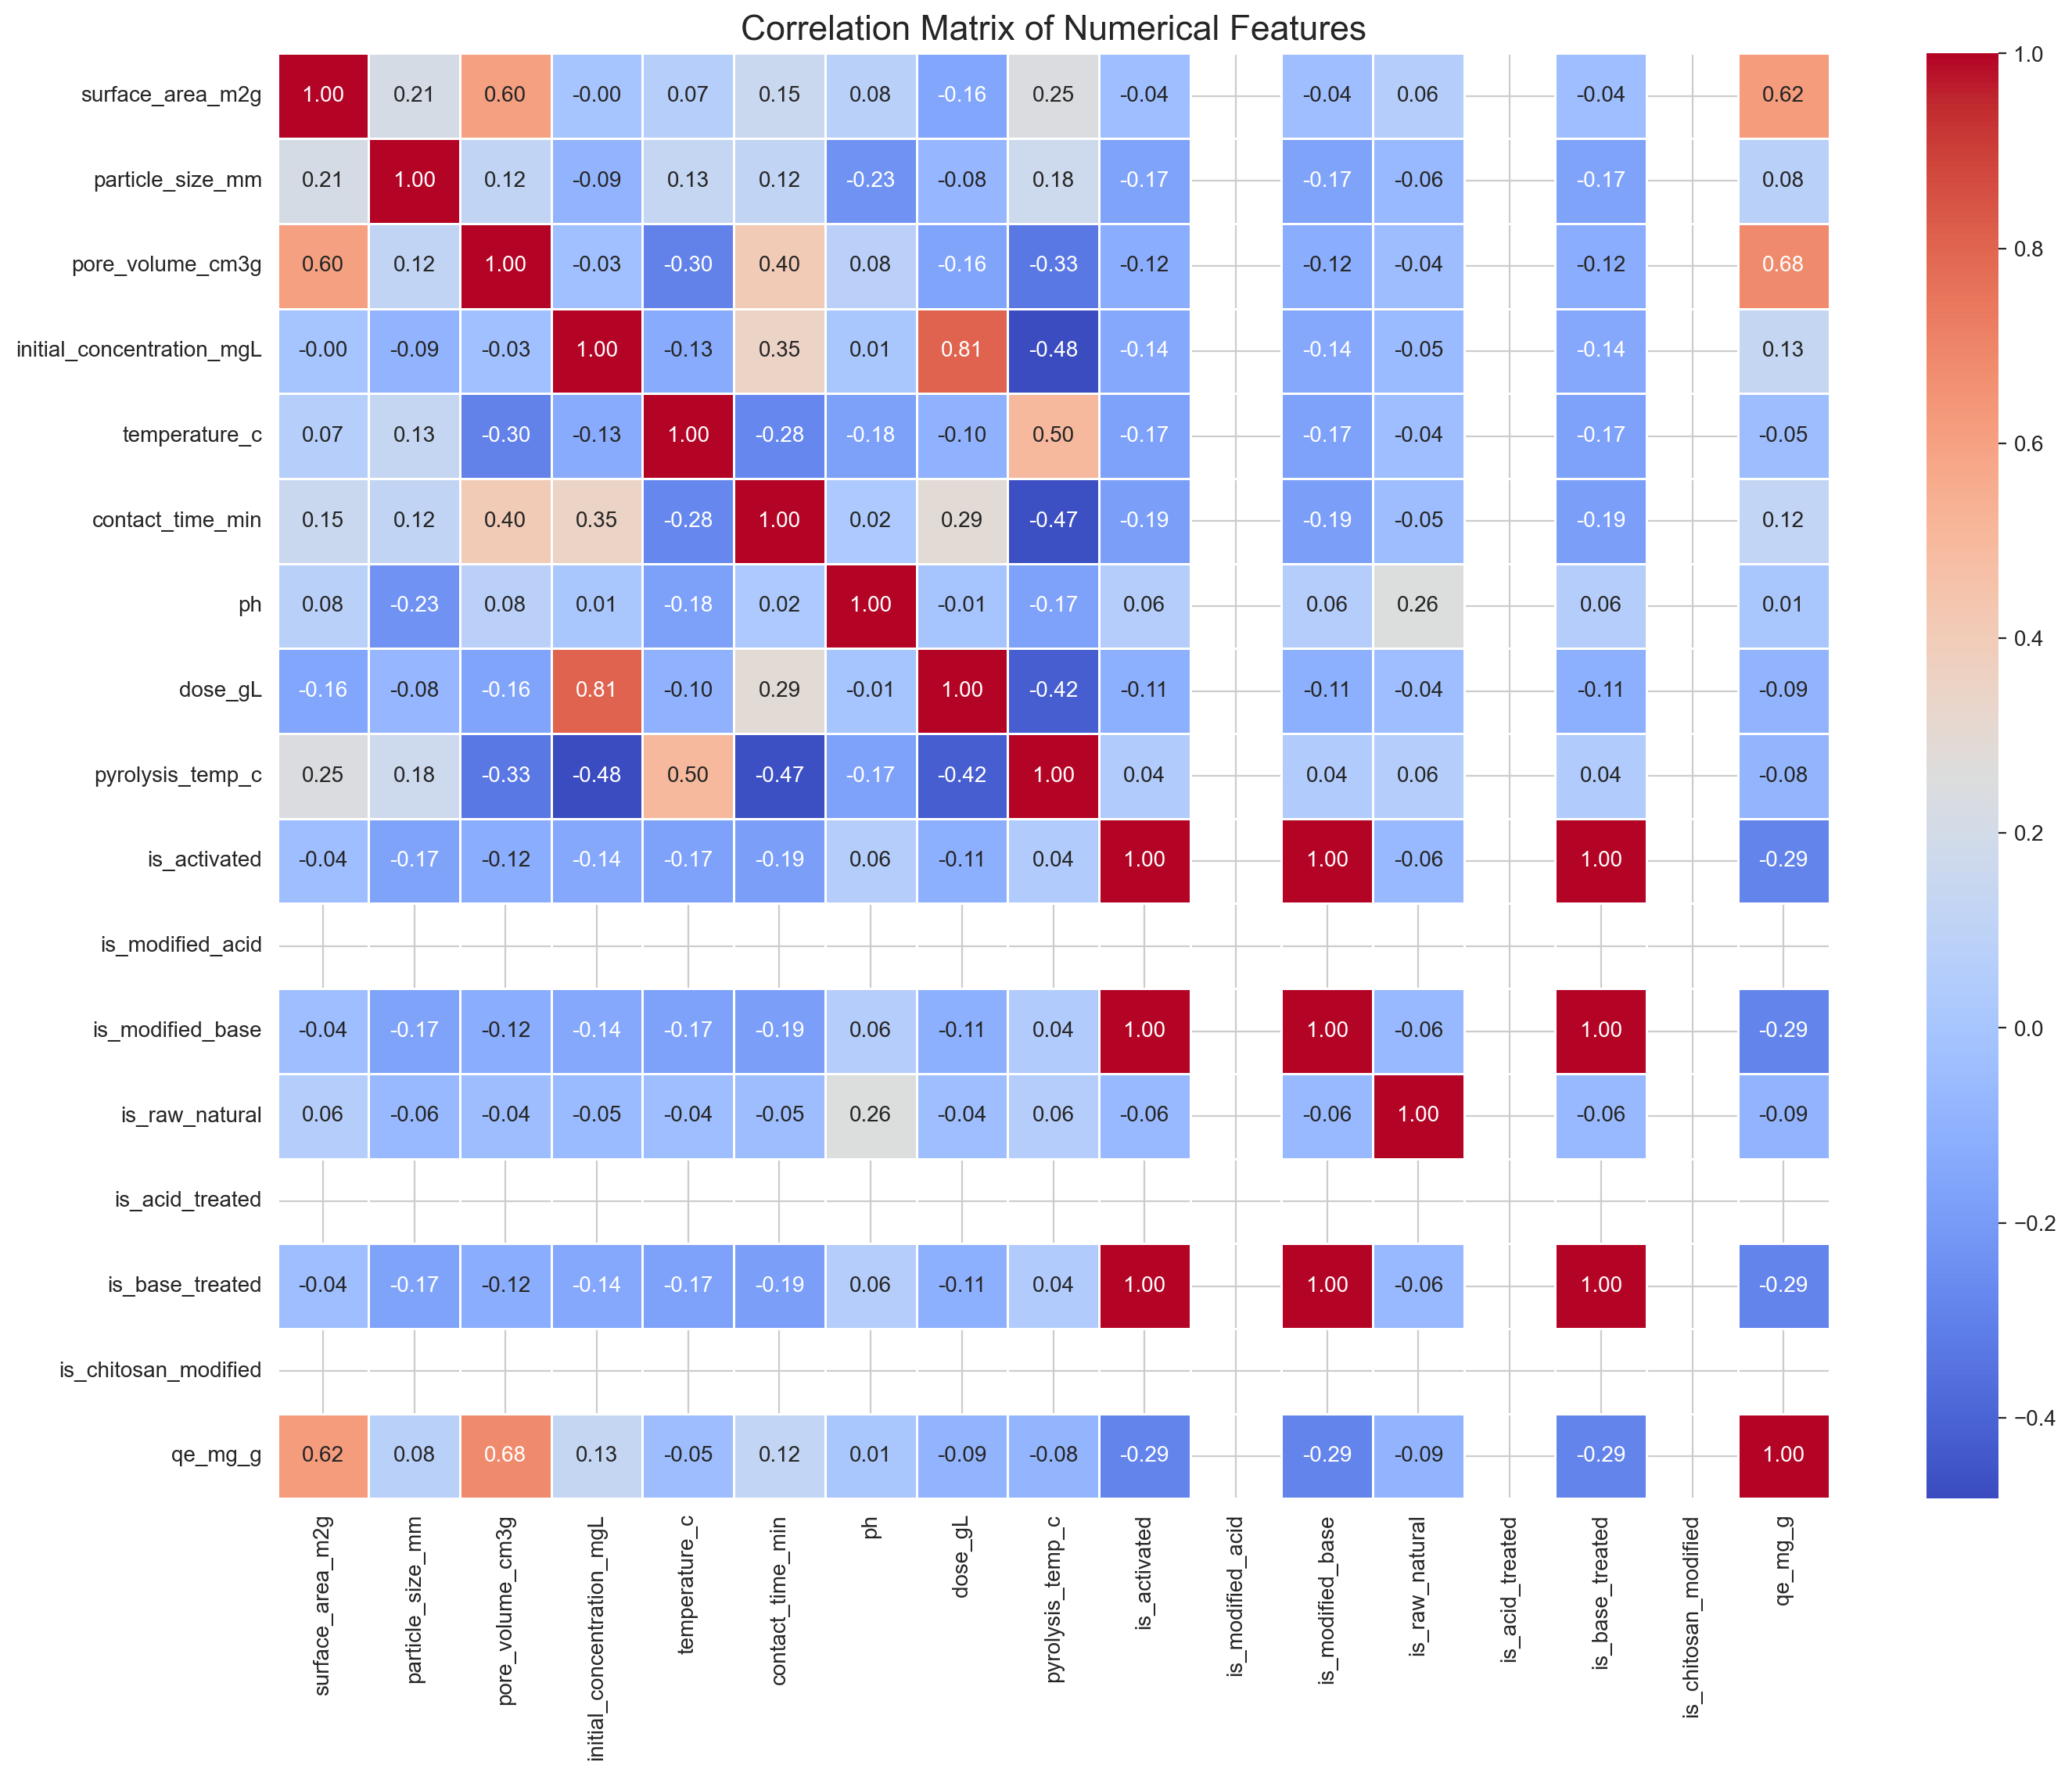

In [18]:
plt.figure(figsize=(16, 12))
# sns.set_style('whitegrid')
# Select only numeric columns for correlation matrix
numeric_df_eda = df_eda.select_dtypes(include=np.number)
corr = numeric_df_eda.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)


# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plot2.png', dpi=500)

plt.show()

## Facet grid: exploring conditional relationships

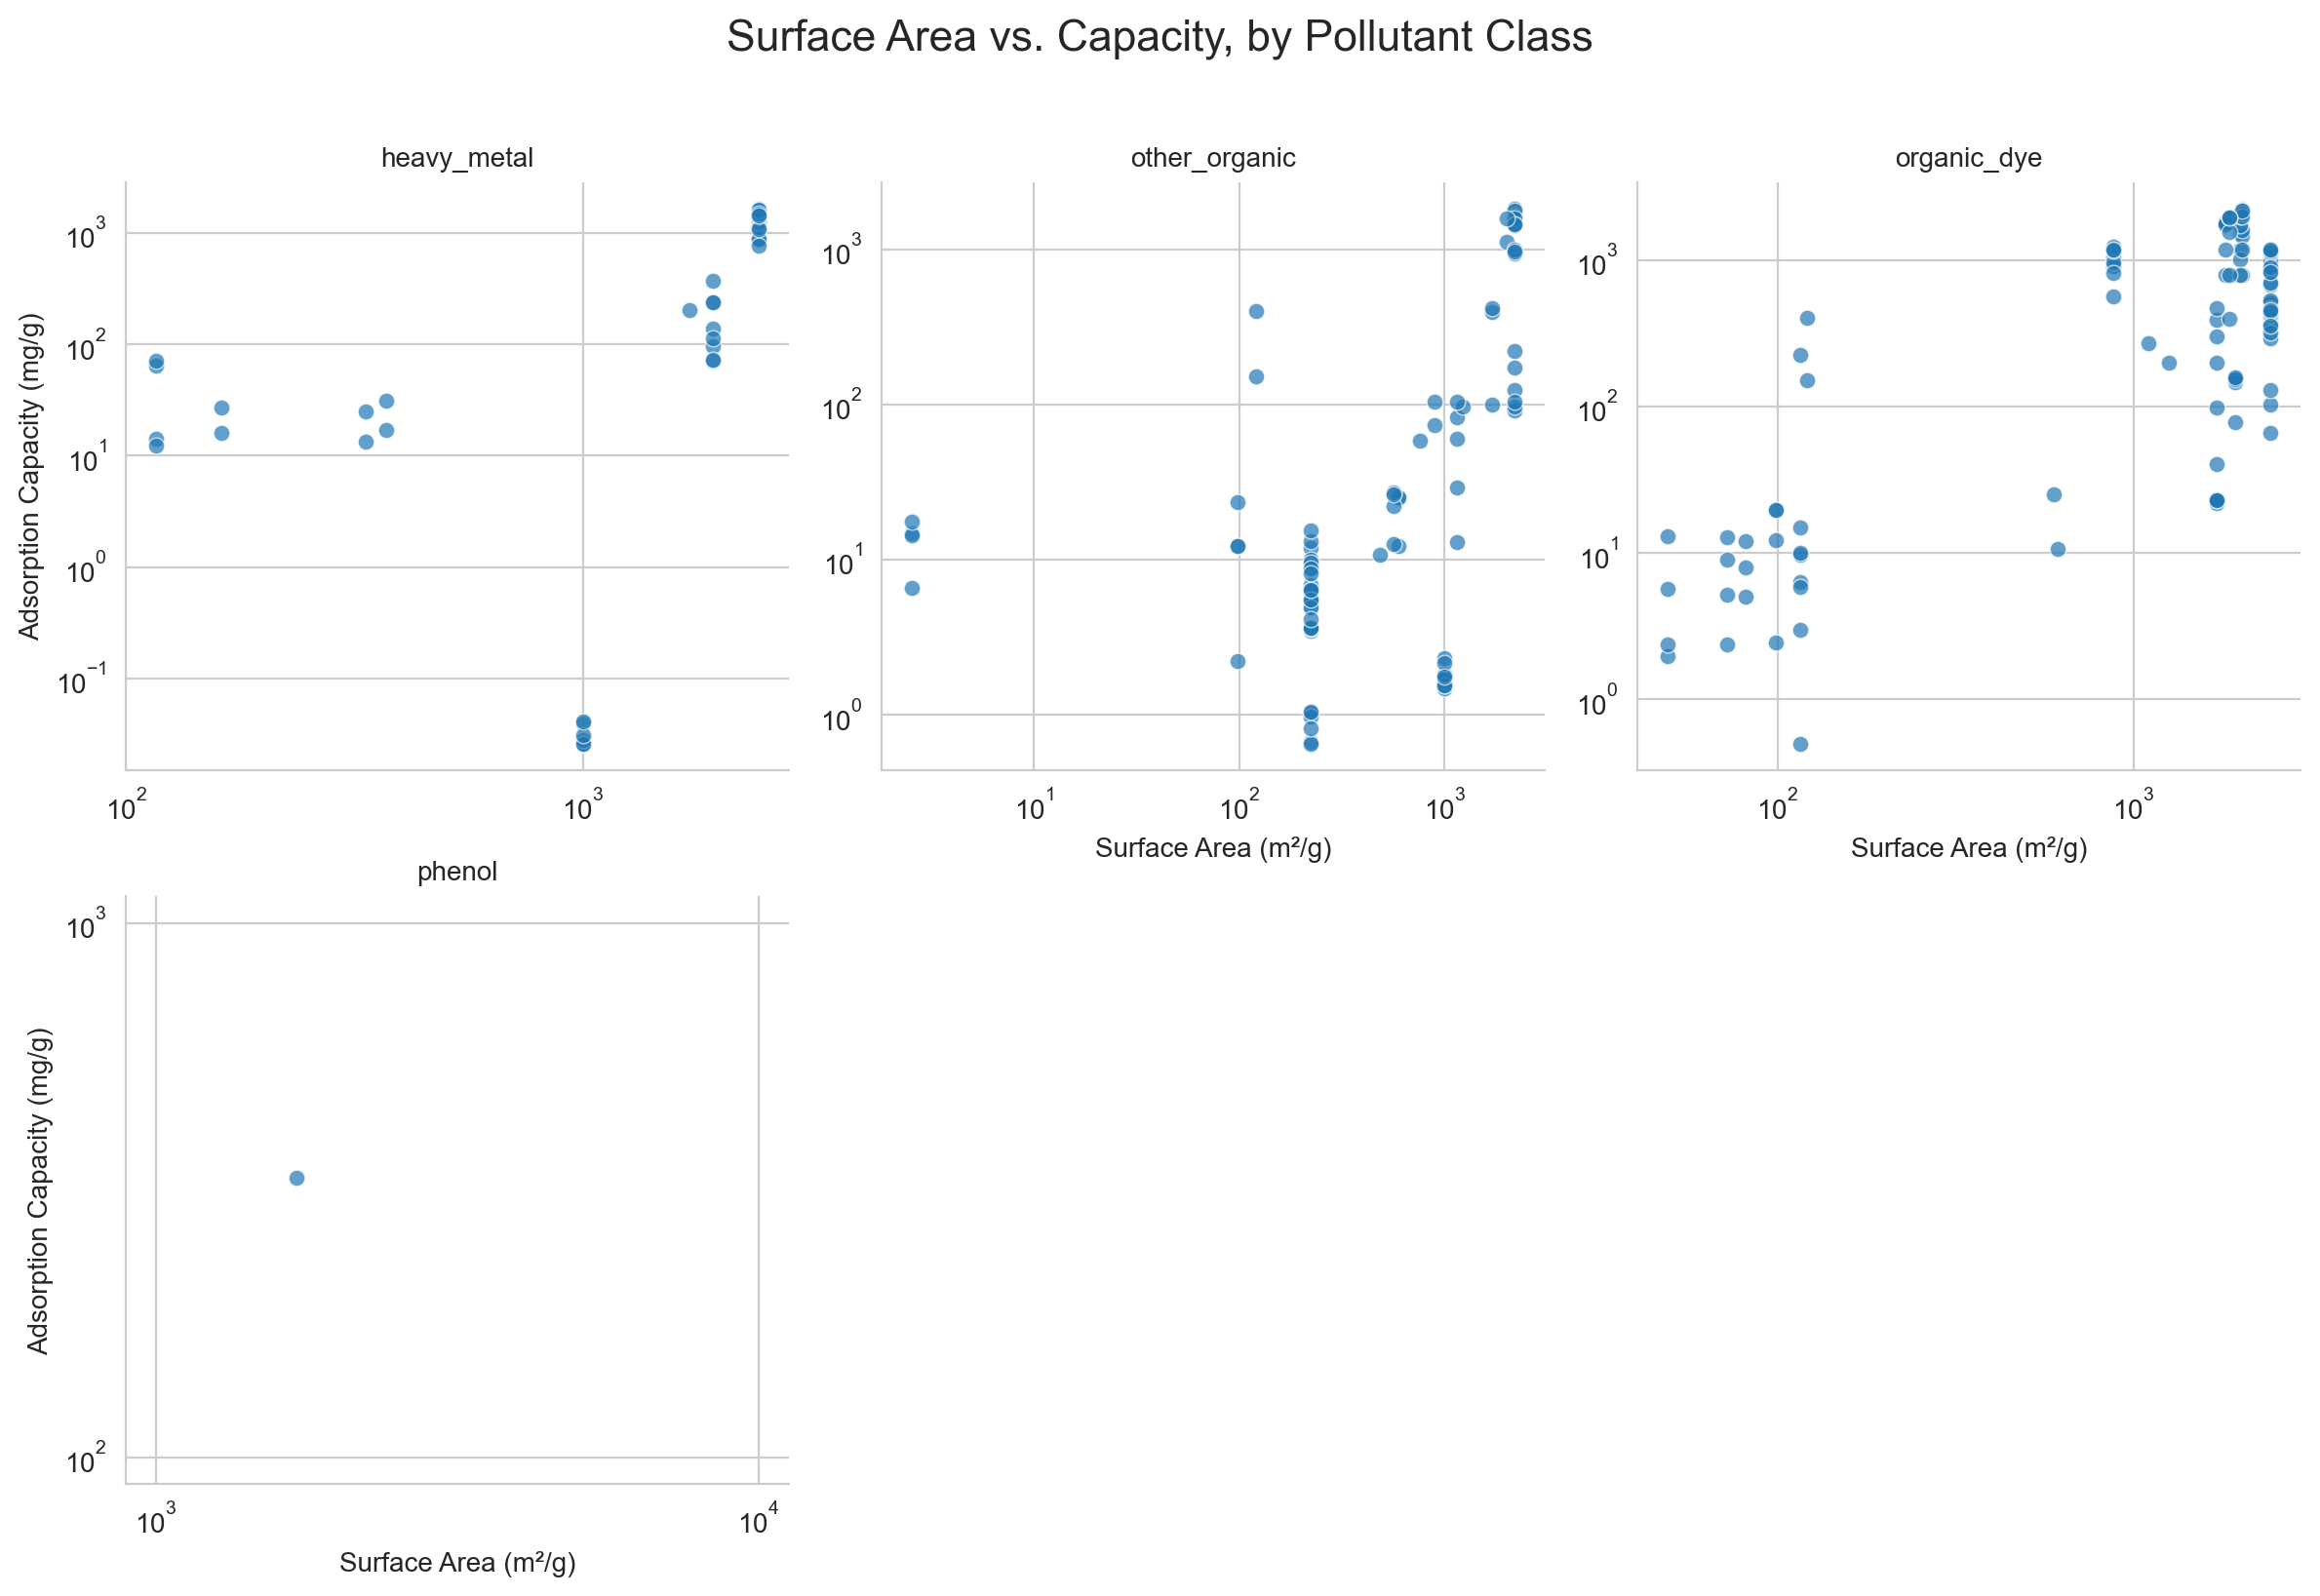

In [19]:
# Create a FacetGrid to see how the relationship between surface area and capacity
# changes for each pollutant class.
g = sns.FacetGrid(df_eda, col="pollutant_class", col_wrap=3, height=4, sharex=False, sharey=False)
g.map(sns.scatterplot, 'surface_area_m2g', 'qe_mg_g', alpha=0.7)
g.set_titles("{col_name}")
g.set_xlabels("Surface Area (m²/g)")
g.set_ylabels("Adsorption Capacity (mg/g)")
# Use log scales on each subplot
for ax in g.axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
plt.suptitle('Surface Area vs. Capacity, by Pollutant Class', y=1.02, fontsize=16)
plt.tight_layout()

# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plot2.png', dpi=500)

plt.show()

## Encoding categorical data

In [20]:
# Identify categorical columns for one-hot encoding
categorical_cols = df_model_input.select_dtypes(include=['object', 'category']).columns

# Perform one-hot encoding
# Initialize the encoder
# handle_unknown='ignore' is important. It tells the encoder to ignore (create all-zero columns for)
# any category that appears in the test set but was not in the training set.
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# Fit on the training data and transform it
X_train_encoded_array = encoder.fit_transform(X_train[categorical_cols])

# Transform the test data using the same fitted encoder
X_test_encoded_array = encoder.transform(X_test[categorical_cols])

# The output is a NumPy array, we need to convert it back to a DataFrame
# and concatenate it with numerical data.

# Create DataFrames with new column names
X_train_encoded = pd.DataFrame(X_train_encoded_array, index=X_train.index, columns=encoder.get_feature_names_out(categorical_cols))
X_test_encoded = pd.DataFrame(X_test_encoded_array, index=X_test.index, columns=encoder.get_feature_names_out(categorical_cols))

# Drop the original categorical columns from X_train and X_test
X_train_final = X_train.drop(columns=categorical_cols)
X_test_final = X_test.drop(columns=categorical_cols)

# Concatenate the numerical data with the new encoded columns
X_train = pd.concat([X_train_final, X_train_encoded], axis=1)
X_test = pd.concat([X_test_final, X_test_encoded], axis=1)

# Handling outliers by capping


In [23]:


print("--- Handling Outliers using IQR Capping ---")

# 1. Identify the numerical columns to cap (same as the ones you scale)
numerical_cols = X_train.select_dtypes(include=np.number).columns
cols_to_cap = [col for col in numerical_cols if X_train[col].nunique() > 2]

# 2. Loop through each column to calculate bounds and apply capping
for col in cols_to_cap:
    # Calculate Q1, Q3, and IQR from the TRAINING data ONLY
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define the upper and lower bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Capping '{col}': Lower Bound={lower_bound:.2f}, Upper Bound={upper_bound:.2f}")

    # Apply the capping to BOTH the training and test sets
    X_train[col] = np.where(X_train[col] < lower_bound, lower_bound, X_train[col])
    X_train[col] = np.where(X_train[col] > upper_bound, upper_bound, X_train[col])

    X_test[col] = np.where(X_test[col] < lower_bound, lower_bound, X_test[col])
    X_test[col] = np.where(X_test[col] > upper_bound, upper_bound, X_test[col])

print("\nOutlier capping complete.")


--- Handling Outliers using IQR Capping ---
Capping 'surface_area_m2g': Lower Bound=-2740.50, Upper Bound=5159.50
Capping 'particle_size_mm': Lower Bound=-0.42, Upper Bound=1.50
Capping 'pore_volume_cm3g': Lower Bound=-0.34, Upper Bound=1.05
Capping 'initial_concentration_mgL': Lower Bound=-475.00, Upper Bound=925.00
Capping 'temperature_c': Lower Bound=17.50, Upper Bound=37.50
Capping 'contact_time_min': Lower Bound=60.00, Upper Bound=60.00
Capping 'ph': Lower Bound=5.75, Upper Bound=7.75
Capping 'dose_gL': Lower Bound=8.00, Upper Bound=8.00
Capping 'pyrolysis_temp_c': Lower Bound=75.00, Upper Bound=1075.00

Outlier capping complete.


# Interaction features, domain knowledge

In [24]:


print("Original number of features:", X_train.shape[1])

# --- Create new interaction and ratio features ---

# Ratio feature based on domain knowledge
# Add a small constant (1e-6) to the denominator to avoid any potential division-by-zero errors
X_train['conc_dose_ratio'] = X_train['initial_concentration_mgL'] / (X_train['dose_gL'] + 1e-6)
X_test['conc_dose_ratio'] = X_test['initial_concentration_mgL'] / (X_test['dose_gL'] + 1e-6)

# Interaction features based on physical properties
X_train['surface_area_x_pore_volume'] = X_train['surface_area_m2g'] * X_train['pore_volume_cm3g']
X_test['surface_area_x_pore_volume'] = X_test['surface_area_m2g'] * X_test['pore_volume_cm3g']

# Interaction feature based on experimental conditions
X_train['ph_x_temperature'] = X_train['ph'] * X_train['temperature_c']
X_test['ph_x_temperature'] = X_test['ph'] * X_test['temperature_c']

print("New number of features after creating interactions:", X_train.shape[1])



Original number of features: 29
New number of features after creating interactions: 32


## Feature scaling and normalization

In [25]:


# Identify the numerical columns that need scaling.
# This excludes the binary columns created by the OneHotEncoder.
numerical_cols = X_train.select_dtypes(include=np.number).columns
# Filter out the one-hot encoded columns which are typically of type uint8 or int64 and have only 0s and 1s
# A simple way is to find columns that are NOT just 0s and 1s.
cols_to_scale = [col for col in numerical_cols if X_train[col].nunique() > 2]

print("Columns to be scaled:", cols_to_scale)

# Initialize the Scaler
scaler = StandardScaler()

# Create a copy to avoid modifying the original
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit and transform only the selected columns
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("\nFeature scaling complete.")
display(X_train_scaled.head())

Columns to be scaled: ['surface_area_m2g', 'particle_size_mm', 'pore_volume_cm3g', 'initial_concentration_mgL', 'temperature_c', 'ph', 'pyrolysis_temp_c', 'conc_dose_ratio', 'surface_area_x_pore_volume', 'ph_x_temperature']

Feature scaling complete.


,surface_area_m2g,particle_size_mm,pore_volume_cm3g,initial_concentration_mgL,temperature_c,contact_time_min,ph,dose_gL,pyrolysis_temp_c,is_activated,is_modified_acid,is_modified_base,is_raw_natural,is_acid_treated,is_base_treated,is_chitosan_modified,activation_agent_NaOH,activation_agent_None,base_material_corn_based,base_material_fruit_waste,base_material_other,base_material_rice_based,material_class_biochar,material_class_hydrochar,material_class_raw_biomass,material_class_unknown_class,pollutant_class_organic_dye,pollutant_class_other_organic,pollutant_class_phenol,conc_dose_ratio,surface_area_x_pore_volume,ph_x_temperature
183,1.178627,-1.131513,-0.252552,1.421481,-0.341146,60.0,0.362382,8.0,1.262319,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.421481,0.153236,-0.214459
323,-0.232640,1.745827,0.168919,-0.607410,-0.341146,60.0,0.980517,8.0,0.672150,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.607410,-0.288445,0.005536
299,-0.833390,1.745827,-0.312762,-0.342936,-0.341146,60.0,-2.213178,8.0,0.377065,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.342936,-0.788102,-1.131102
92,0.558109,0.062050,1.340307,0.903868,-0.341146,60.0,0.362382,8.0,-0.803273,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.903868,1.146383,-0.214459
11,-0.956396,-0.236341,-0.252552,-0.418500,-0.341146,60.0,0.362382,8.0,0.672150,1,0,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.418500,-0.829205,-0.214459


## Modeling

## 1. Linear regression

In [27]:
# --- Train and Evaluate the Baseline Model (Linear Regression) ---
print("--- 1. Training Baseline Model: Linear Regression ---")
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_lr = linear_model.predict(X_test_scaled)

# Evaluate on the test set
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("Linear Regression evaluation complete.\n")



--- 1. Training Baseline Model: Linear Regression ---
Linear Regression evaluation complete.



In [28]:
print(f"Baseline R-squared (R²): {r2_lr:.4f}")
print(f"Baseline Root Mean Squared Error (RMSE): {rmse_lr:.4f}\n")

Baseline R-squared (R²): 0.7405
Baseline Root Mean Squared Error (RMSE): 331.8908



## No cross validation/ Log Transformation

In [29]:

# ---  Model Training ---
print("--- Experiment 1: RF Model without LogT ---")

# Initialize and train the model on your scaled training data
rf_baseline = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_baseline_rf = rf_baseline.predict(X_test_scaled)

# Evaluate the performance
mse_baseline_rf = mean_squared_error(y_test, y_pred_baseline_rf)
r2_baseline_rf = r2_score(y_test, y_pred_baseline_rf)

print(f"RF R-squared (R²): {r2_baseline_rf:.4f}")
print(f"RF Root Mean Squared Error (RMSE): {np.sqrt(mse_baseline_rf):.4f}\n")



# ---  Model Training ---
print("--- Experiment 1: XGB Model without LogT ---")

# Initialize and train the model on your scaled training data
x_baseline = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
x_baseline.fit(X_train_scaled, y_train)
    
# Make predictions on the test set
y_pred_baseline_x = x_baseline.predict(X_test_scaled)

# Evaluate the performance
mse_baseline_x = mean_squared_error(y_test, y_pred_baseline_x)
r2_baseline_x = r2_score(y_test, y_pred_baseline_x)

print(f"XGB R-squared (R²): {r2_baseline_x:.4f}")
print(f"XGB Root Mean Squared Error (RMSE): {np.sqrt(mse_baseline_x):.4f}\n")

--- Experiment 1: RF Model without LogT ---
RF R-squared (R²): 0.9563
RF Root Mean Squared Error (RMSE): 136.2421

--- Experiment 1: XGB Model without LogT ---
XGB R-squared (R²): 0.9611
XGB Root Mean Squared Error (RMSE): 128.4487



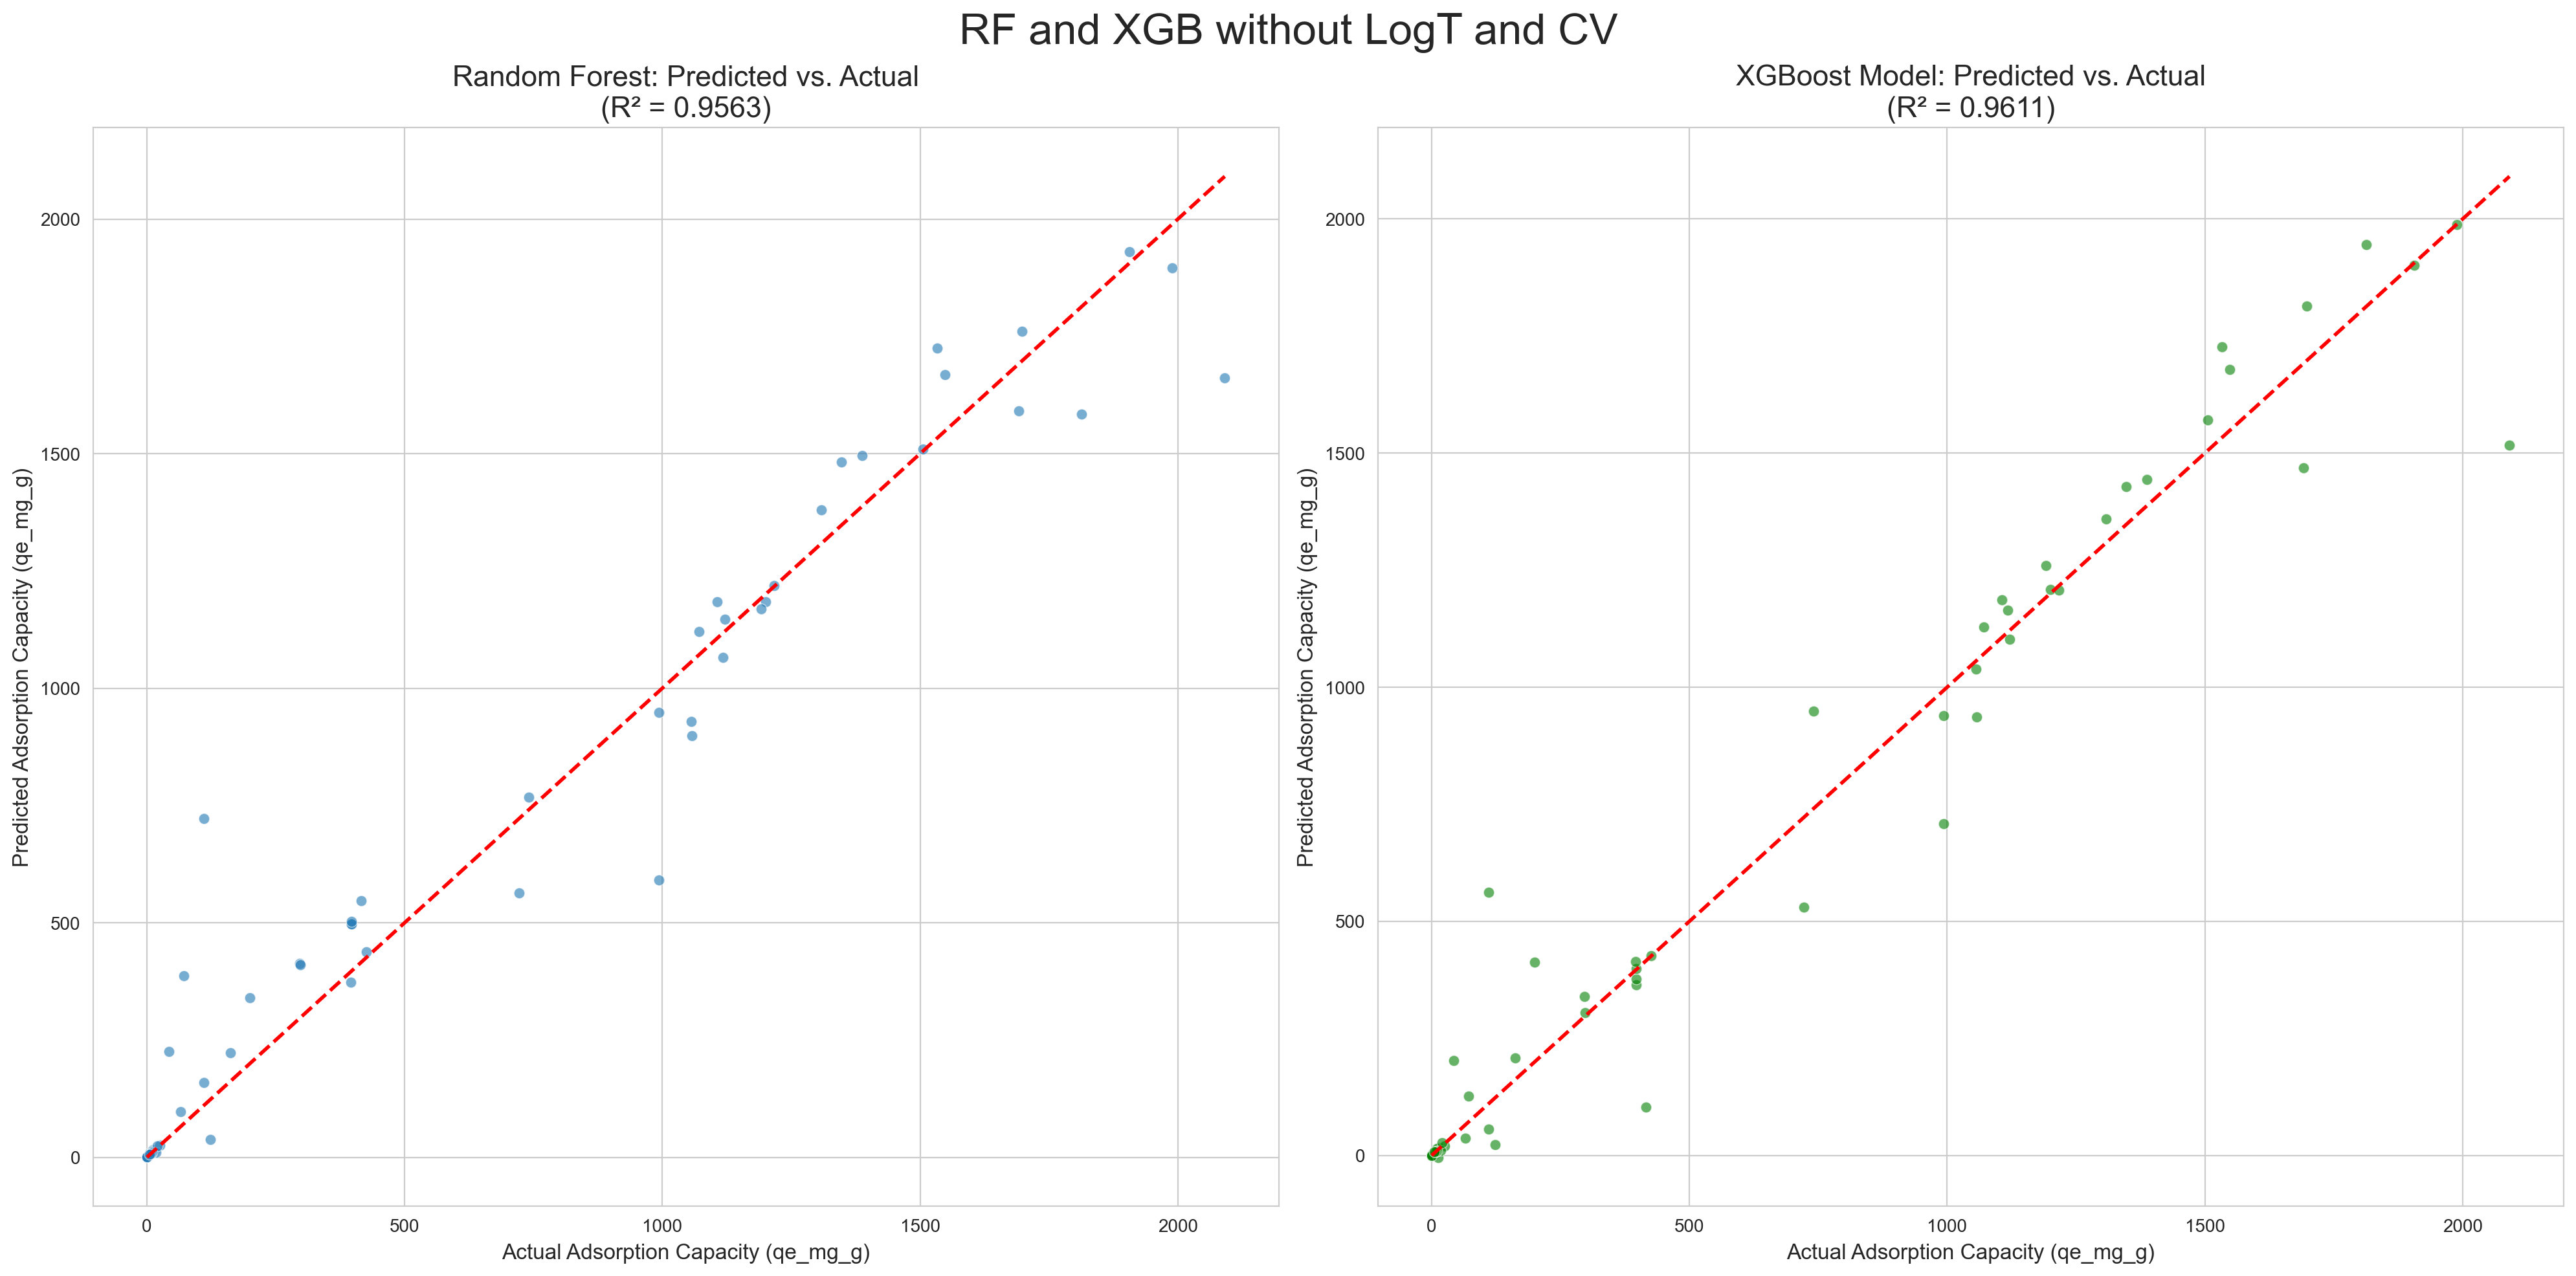

In [30]:


# --- Model performance plot ---


fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('RF and XGB without LogT and CV', fontsize=24)
sns.set_style("whitegrid")

# --- Plot 1: Random Forest ---
# Fix: Specify axes[0] instead of axes for the first subplot
sns.scatterplot(x=y_test, y=y_pred_baseline_rf, ax=axes[0], alpha=0.6)
axes[0].set_title(f'Random Forest: Predicted vs. Actual\n(R² = {r2_baseline_rf:.4f})', fontsize=16)
axes[0].set_xlabel('Actual Adsorption Capacity (qe_mg_g)', fontsize=12)
axes[0].set_ylabel('Predicted Adsorption Capacity (qe_mg_g)', fontsize=12)

# Add the "perfect prediction" line
max_val = max(y_test.max(), y_pred_baseline_rf.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2) # Dashed red line

# --- Plot 2: XGBoost (Best Model) ---
sns.scatterplot(x=y_test, y=y_pred_baseline_x, ax=axes[1], alpha=0.6, color='green')
axes[1].set_title(f'XGBoost Model: Predicted vs. Actual\n(R² = {r2_baseline_x:.4f})', fontsize=16)
axes[1].set_xlabel('Actual Adsorption Capacity (qe_mg_g)', fontsize=12)
axes[1].set_ylabel('Predicted Adsorption Capacity (qe_mg_g)', fontsize=12)

# Add the "perfect prediction" line
max_val = max(y_test.max(), y_pred_baseline_x.max())
axes[1].plot([0, max_val], [0, max_val], 'r--', lw=2) # Dashed red line

# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plot.png', dpi=500) 


plt.tight_layout()
plt.show()

In [31]:
print(y_test.min(), y_test.max())

0.025 2091.0


##  RF With Log transform

In [32]:
# --- Log Transformation of the Target Variable with RF model ---
print("--- Experiment 2: Model with Log-Transformed Target ---")

# Apply the log1p transformation to the training and test target data
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test) # We'll use the original y_test for final evaluation

# Initialize and train a new model on the log-transformed target
rf_log = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_log.fit(X_train_scaled, y_train_log)

# Make predictions (these will be on the log scale)
y_pred_log_rf = rf_log.predict(X_test_scaled)

# --- CRITICAL STEP: Inverse Transform the Predictions ---
# We must convert the predictions back to the original scale before evaluation
y_pred_original_scale_rf = np.expm1(y_pred_log_rf)

# Evaluate the performance against the original, un-transformed y_test
mse_log_rf = mean_squared_error(y_test, y_pred_original_scale_rf)
r2_log_rf = r2_score(y_test, y_pred_original_scale_rf)

print(f"Log-Transformed R-squared (R²): {r2_log_rf:.4f}")
print(f"Log-Transformed Root Mean Squared Error (RMSE): {np.sqrt(mse_log_rf):.4f}\n")

--- Experiment 2: Model with Log-Transformed Target ---
Log-Transformed R-squared (R²): 0.9316
Log-Transformed Root Mean Squared Error (RMSE): 170.4507



## XGB with log Transformation

In [33]:
# --- Log Transformation of the Target Variable with XGB model---
print("--- Experiment 2: Model with Log-Transformed Target ---")

# Apply the log1p transformation to the training and test target data
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test) # We'll use the original y_test for final evaluation

# Initialize and train a new model on the log-transformed target
xgb_log = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_log.fit(X_train_scaled, y_train_log)

# Make predictions (these will be on the log scale)
y_pred_log_xgb = xgb_log.predict(X_test_scaled)

# --- CRITICAL STEP: Inverse Transform the Predictions ---
# We must convert the predictions back to the original scale before evaluation
y_pred_original_scale_xgb = np.expm1(y_pred_log_xgb)

# Evaluate the performance against the original, un-transformed y_test
mse_log_xgb = mean_squared_error(y_test, y_pred_original_scale_xgb)
r2_log_xgb = r2_score(y_test, y_pred_original_scale_xgb)

print(f"Log-Transformed R-squared (R²): {r2_log_xgb:.4f}")
print(f"Log-Transformed Root Mean Squared Error (RMSE): {np.sqrt(mse_log_xgb):.4f}\n")

--- Experiment 2: Model with Log-Transformed Target ---
Log-Transformed R-squared (R²): 0.9487
Log-Transformed Root Mean Squared Error (RMSE): 147.5701



## Performance Plots for RF and XGB with Log transform

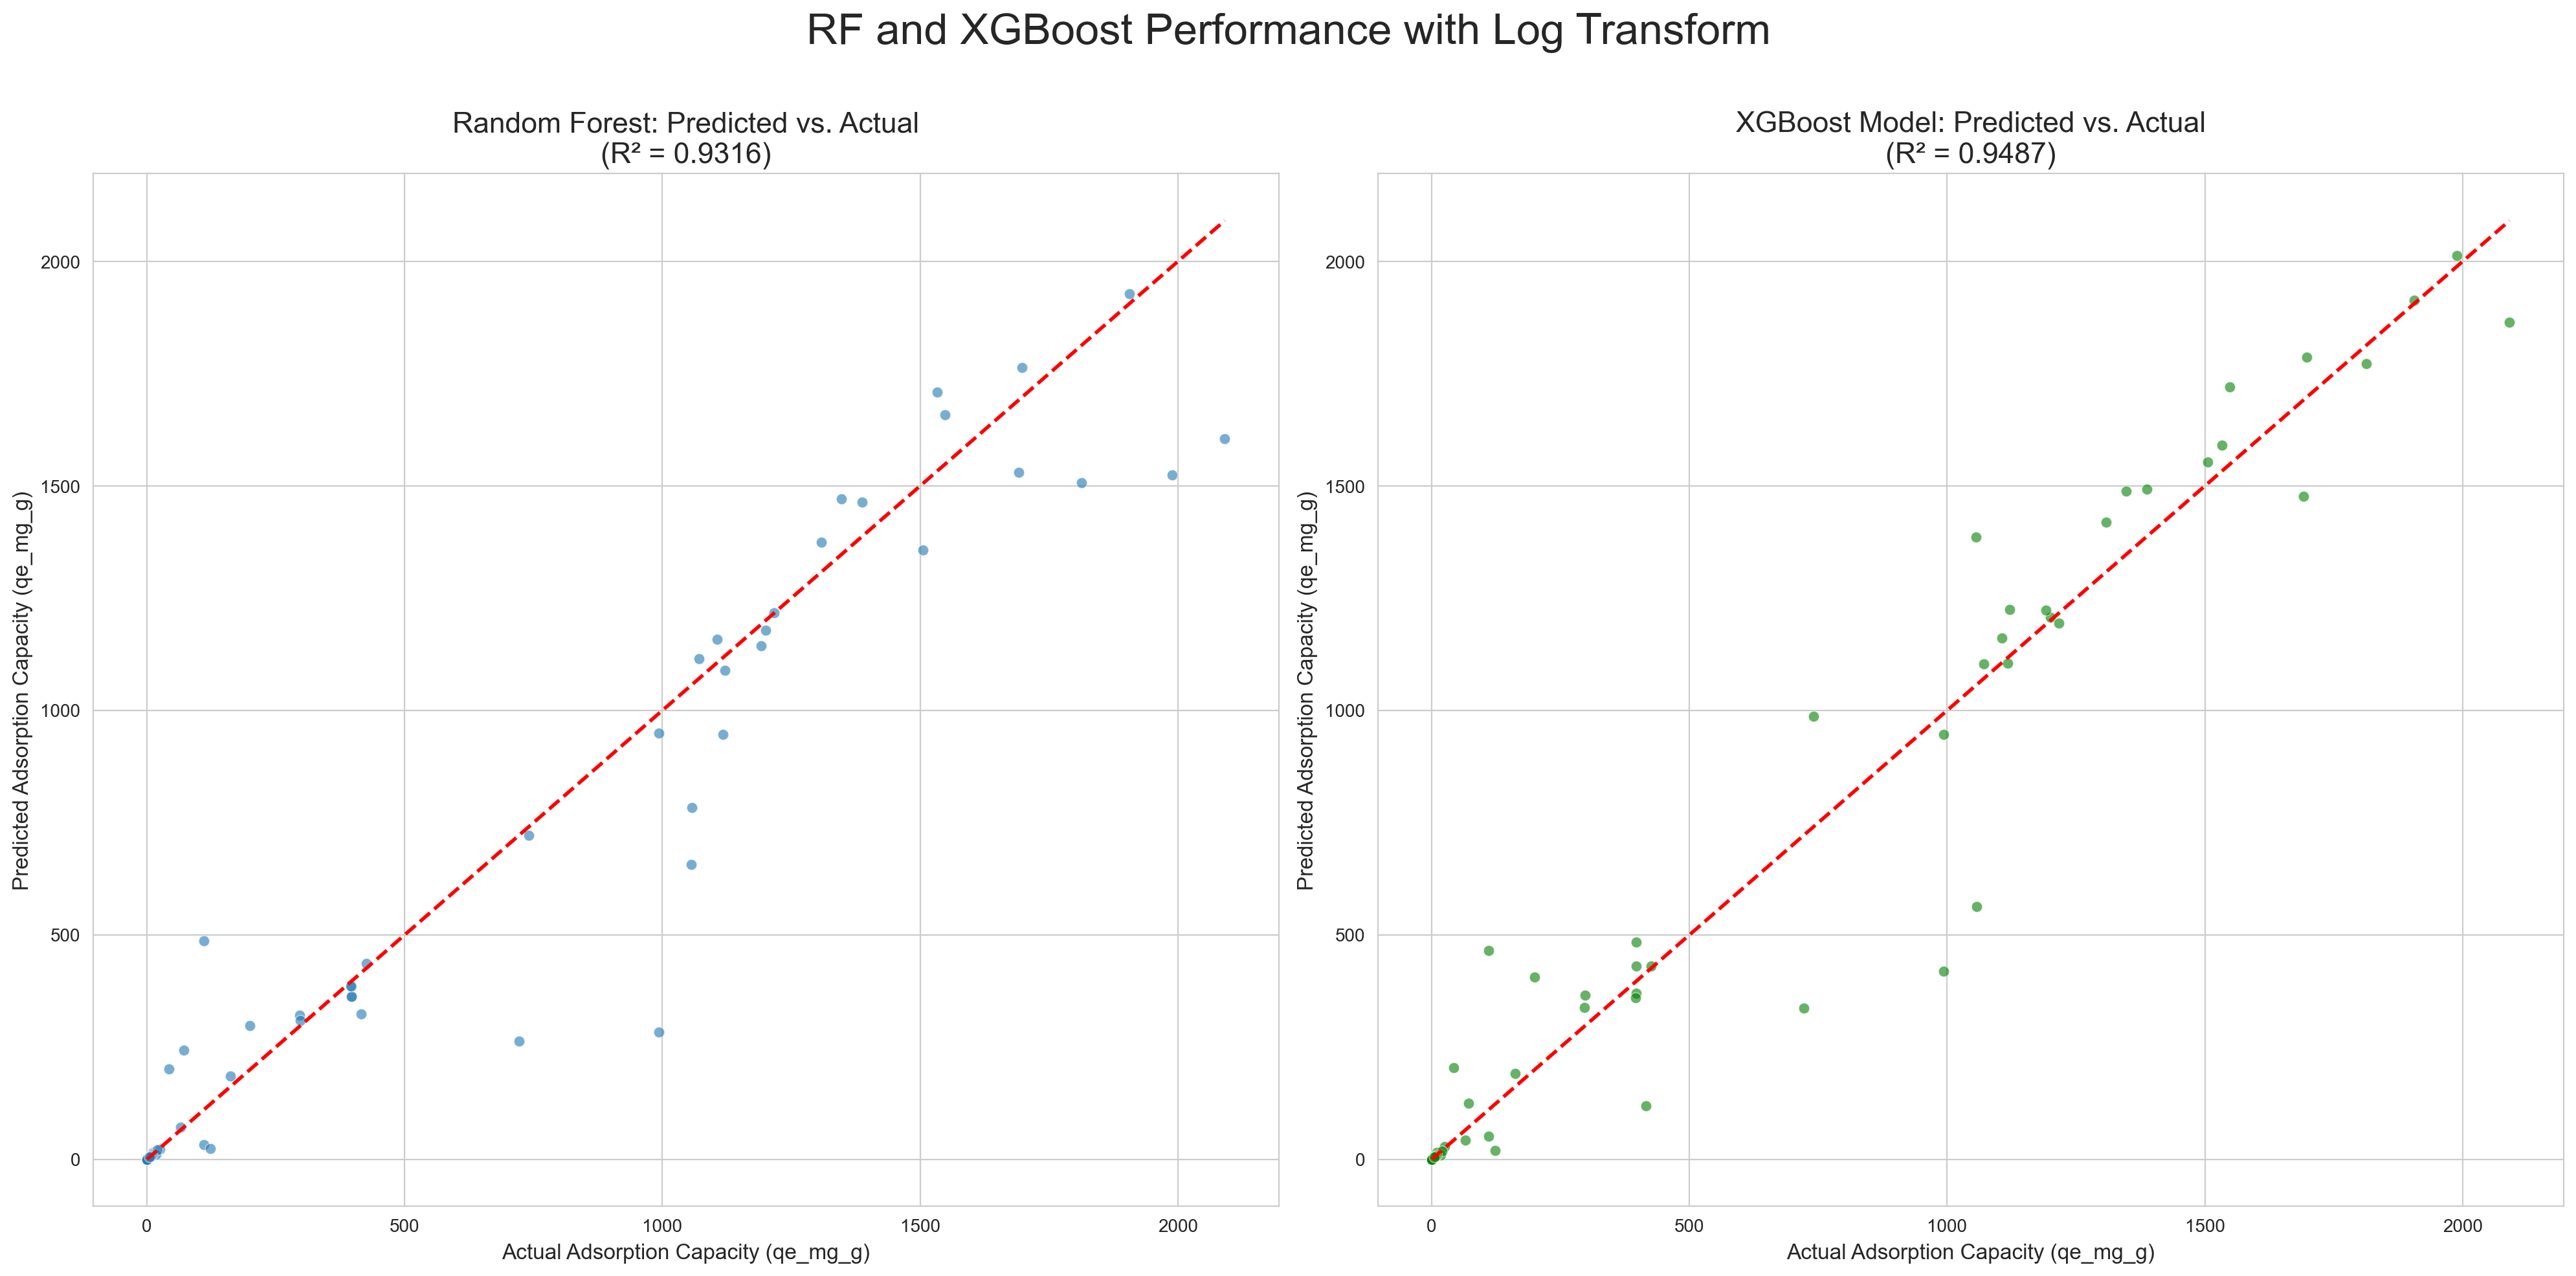

In [34]:
# y_test, y_pred_original_scale_rf, y_pred_original_scale_xgb, r2_log_rf, r2_log_xgb

# --- Create a figure with two subplots side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('RF and XGBoost Performance with Log Transform\n', fontsize=24)
sns.set_style("whitegrid")

# --- Plot 1: Random Forest ---
# Fix: Specify axes[0] instead of axes for the first subplot
sns.scatterplot(x=y_test, y=y_pred_original_scale_rf, ax=axes[0], alpha=0.6)
axes[0].set_title(f'Random Forest: Predicted vs. Actual\n(R² = {r2_log_rf:.4f})', fontsize=16)
axes[0].set_xlabel('Actual Adsorption Capacity (qe_mg_g)', fontsize=12)
axes[0].set_ylabel('Predicted Adsorption Capacity (qe_mg_g)', fontsize=12)

# Add the "perfect prediction" line
max_val = max(y_test.max(), y_pred_log_rf.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2) # Dashed red line

# --- Plot 2: XGBoost (Best Model) ---
sns.scatterplot(x=y_test, y=y_pred_original_scale_xgb, ax=axes[1], alpha=0.6, color='green')
axes[1].set_title(f'XGBoost Model: Predicted vs. Actual\n(R² = {r2_log_xgb:.4f})', fontsize=16)
axes[1].set_xlabel('Actual Adsorption Capacity (qe_mg_g)', fontsize=12)
axes[1].set_ylabel('Predicted Adsorption Capacity (qe_mg_g)', fontsize=12)

# Add the "perfect prediction" line
max_val = max(y_test.max(), y_pred_log_xgb.max())
axes[1].plot([0, max_val], [0, max_val], 'r--', lw=2) # Dashed red line

%config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

plt.savefig('my_plot.png', dpi=500)  # You can use 300 or higher for publication quality


plt.tight_layout()
plt.show()

<!-- ## Robust comparison -->

## Hyperparameter Tuning with Cross-Validation

In [35]:
# Hyperparameter Tuning with Cross-Validation for Advanced Models

# Define the Parameter Grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3]
}

# Define the Parameter Grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 3, 5]
}

# Set up and Run GridSearchCV for Random Forest
print("--- 2. Tuning Advanced Model: Random Forest (using 5-fold Cross-Validation) ---")
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=param_grid_rf, cv=5, n_jobs=-1, scoring='r2', verbose=2)
grid_search_rf.fit(X_train_scaled, y_train)
best_rf_model = grid_search_rf.best_estimator_
print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")

# actual RF model prediction
y_pred_rf = best_rf_model.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forest tuning and evaluation complete.\n")





--- 2. Tuning Advanced Model: Random Forest (using 5-fold Cross-Validation) ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 200}
Random Forest tuning and evaluation complete.



In [36]:
# Set up and Run GridSearchCV for XGBoost
print("--- 3. Tuning Advanced Model: XGBoost (using 5-fold Cross-Validation) ---")
grid_search_xgb = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                               param_grid=param_grid_xgb, cv=5, n_jobs=-1, scoring='r2', verbose=2)
grid_search_xgb.fit(X_train, y_train)
best_xgb_model = grid_search_xgb.best_estimator_
print(f"Best XGBoost Parameters: {grid_search_xgb.best_params_}")

# actual xgboost model prediction
y_pred_xgb = best_xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("XGBoost tuning and evaluation complete.\n")

--- 3. Tuning Advanced Model: XGBoost (using 5-fold Cross-Validation) ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best XGBoost Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
XGBoost tuning and evaluation complete.



In [37]:

# Final Model Comparison
results_data = {
    'Model':['Linear Regression', 'Random Forest', 'XGBoost'],
    'R-squared (R²) on Test Set': [r2_lr, r2_rf, r2_xgb],
    'RMSE on Test Set (mg/g)': [rmse_lr, rmse_rf, rmse_xgb]
}
results_df = pd.DataFrame(results_data)

print("--- Final Model Performance Comparison ---")
print(results_df.round(4))

# Identify the best model based on R-squared
best_model_index = results_df['R-squared (R²) on Test Set'].idxmax()
best_model_name = results_df.loc[best_model_index, 'Model']
# best_model_name = best_model_row['Model']


# Now, assign the correct trained model object to the 'best_model' variable
if best_model_name == 'XGBoost':
    best_model = best_xgb_model
elif best_model_name == 'Random Forest':
    best_model = best_rf_model
else:
    best_model = linear_model

print(f"The best performing model was identified as: {best_model_name}")

--- Final Model Performance Comparison ---
               Model  R-squared (R²) on Test Set  RMSE on Test Set (mg/g)
0  Linear Regression                      0.7405                 331.8908
1      Random Forest                      0.9496                 146.3374
2            XGBoost                      0.9324                 169.4329
The best performing model was identified as: Random Forest


## SVR

In [58]:

# ---  Model Training of SVR usisng X_train_scaled, y_train, y_test ---
print("--- Experiment 1: SVR Model without LogT ---")

# Initialize and train the model on your scaled training data
# Create an SVR model with an RBF kernel
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)

# training the model
svr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_svr = svr_model.predict(X_test_scaled)


# Evaluate the performance
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR R-squared (R²): {r2_svr:.4f}")
print(f"SVR Root Mean Squared Error (RMSE): {np.sqrt(mse_svr):.4f}\n")





--- Experiment 1: SVR Model without LogT ---
SVR R-squared (R²): -0.3228
SVR Root Mean Squared Error (RMSE): 749.3965



## SVR with hyperpaameter tuning

In [59]:


# Define the parameter grid to search
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5]
}

# Use GridSearchCV with cross-validation
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
print("Best hyperparameters found: ", grid_search.best_params_)

# Evaluate the best model
best_svr = grid_search.best_estimator_
y_pred_tuned = best_svr.predict(X_test_scaled)
tuned_r2 = r2_score(y_test, y_pred_tuned)

print(f"R-squared with tuned model: {tuned_r2:.4f}")


Best hyperparameters found:  {'C': 100, 'epsilon': 0.5, 'kernel': 'linear'}
R-squared with tuned model: 0.6939


## Model Visual

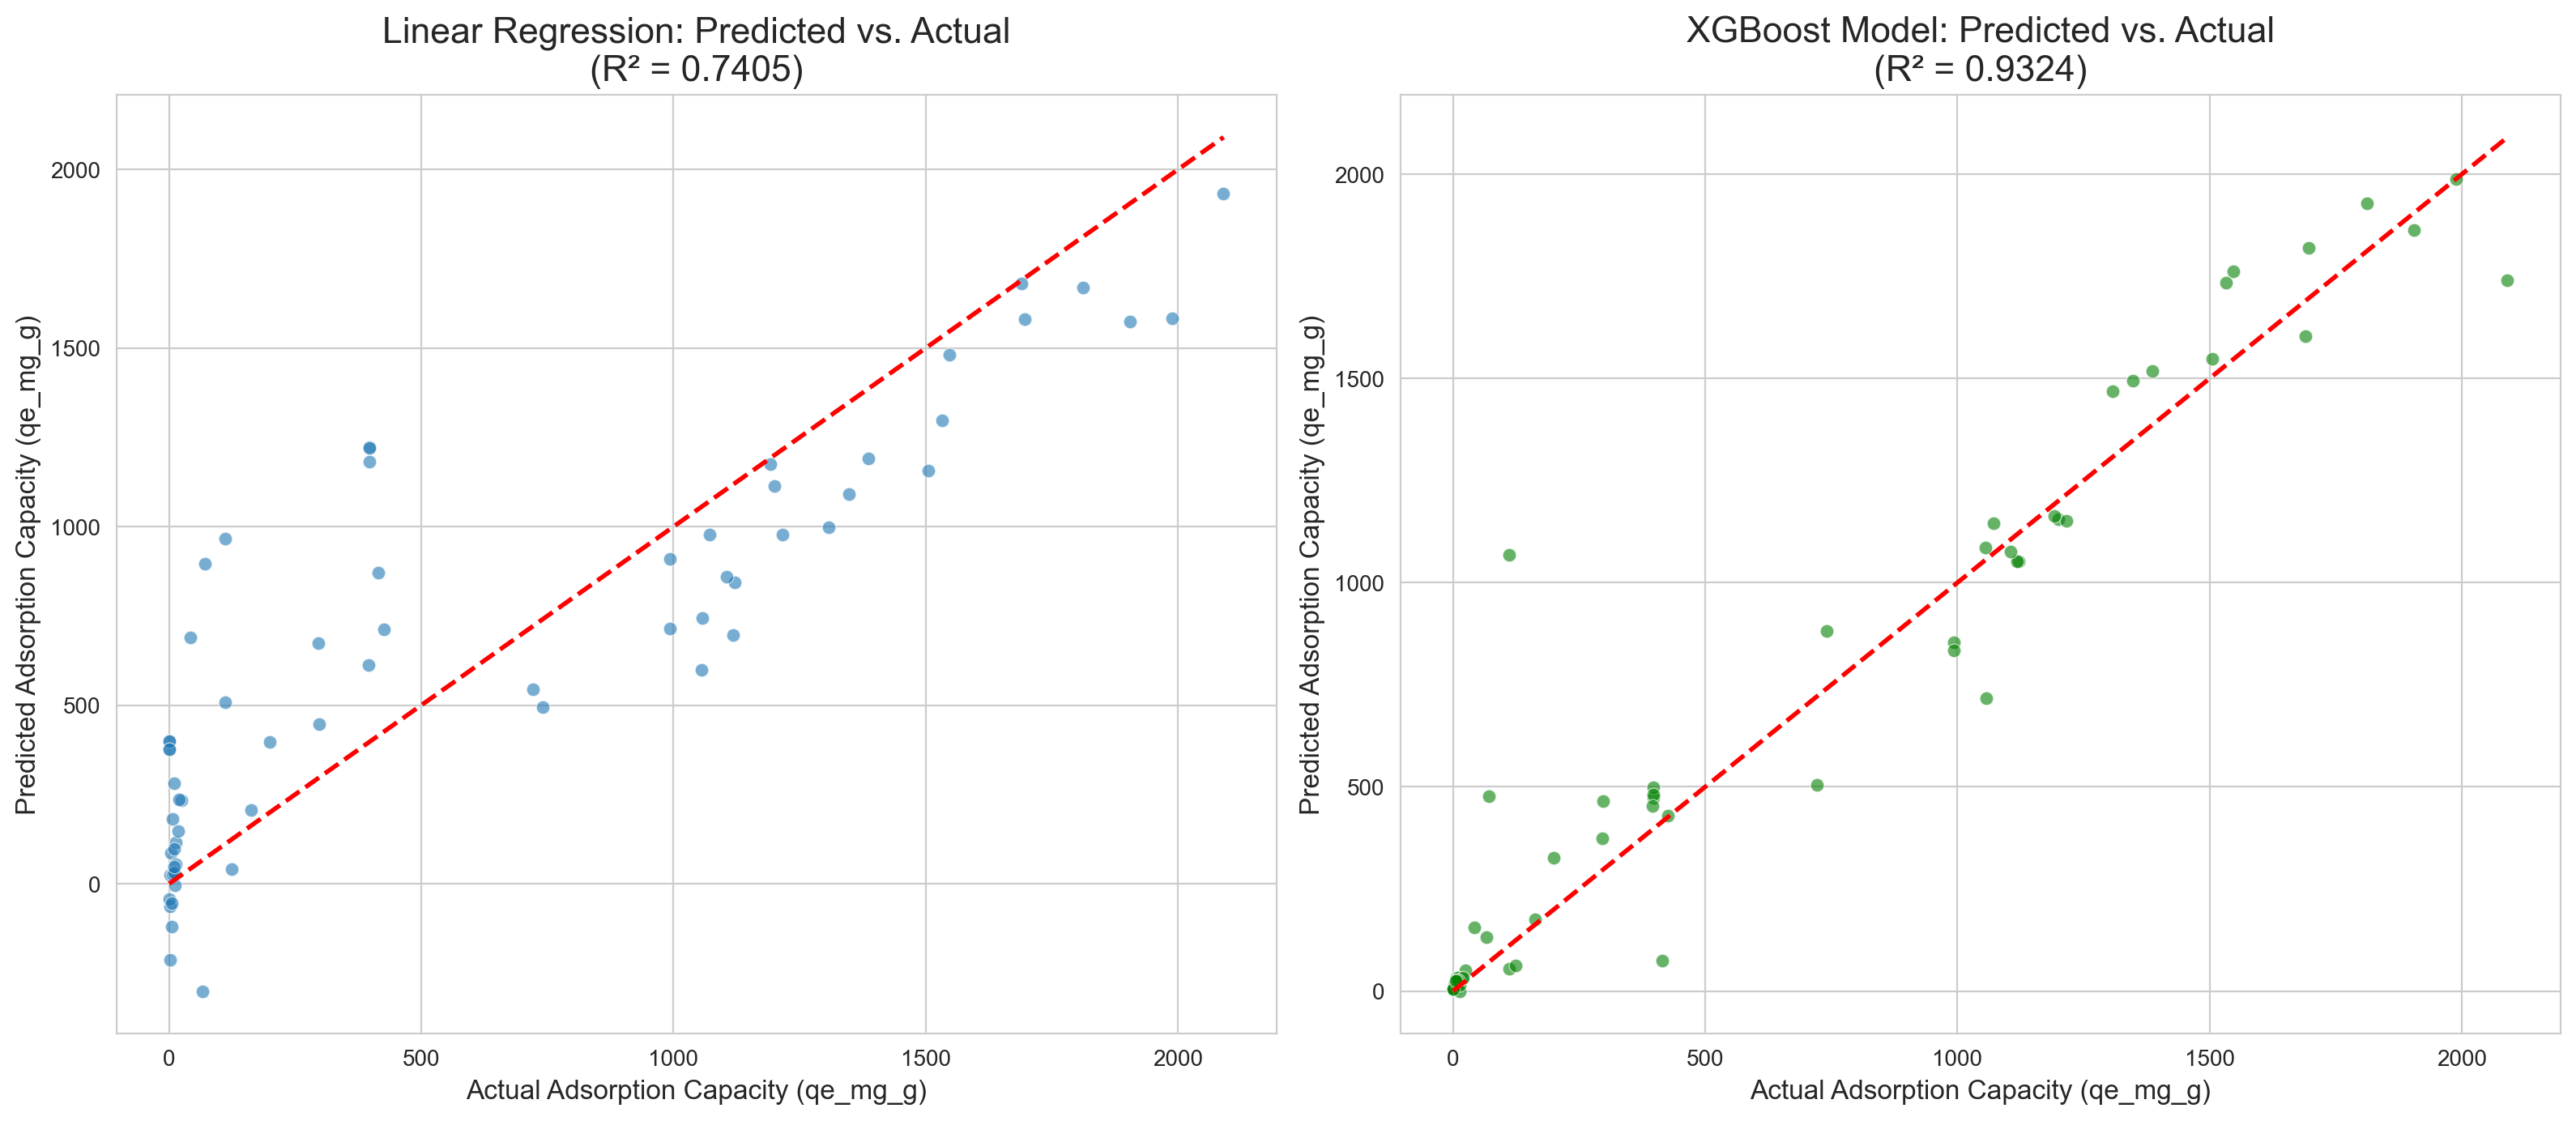

In [39]:

# --- Create a figure with two subplots side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.set_style("whitegrid")

# --- Plot 1: Linear Regression (Baseline Model) ---
# Fix: Specify axes[0] instead of axes for the first subplot
sns.scatterplot(x=y_test, y=y_pred_lr, ax=axes[0], alpha=0.6)
axes[0].set_title(f'Linear Regression: Predicted vs. Actual\n(R² = {r2_lr:.4f})', fontsize=16)
axes[0].set_xlabel('Actual Adsorption Capacity (qe_mg_g)', fontsize=12)
axes[0].set_ylabel('Predicted Adsorption Capacity (qe_mg_g)', fontsize=12)

# Add the "perfect prediction" line
max_val = max(y_test.max(), y_pred_lr.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2) # Dashed red line

# --- Plot 2: XGBoost (Best Model) ---
sns.scatterplot(x=y_test, y=y_pred_xgb, ax=axes[1], alpha=0.6, color='green')
axes[1].set_title(f'XGBoost Model: Predicted vs. Actual\n(R² = {r2_xgb:.4f})', fontsize=16)
axes[1].set_xlabel('Actual Adsorption Capacity (qe_mg_g)', fontsize=12)
axes[1].set_ylabel('Predicted Adsorption Capacity (qe_mg_g)', fontsize=12)

# Add the "perfect prediction" line
max_val = max(y_test.max(), y_pred_xgb.max())
axes[1].plot([0, max_val], [0, max_val], 'r--', lw=2) # Dashed red line

# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plot.png', dpi=500)  


plt.tight_layout()
plt.show()

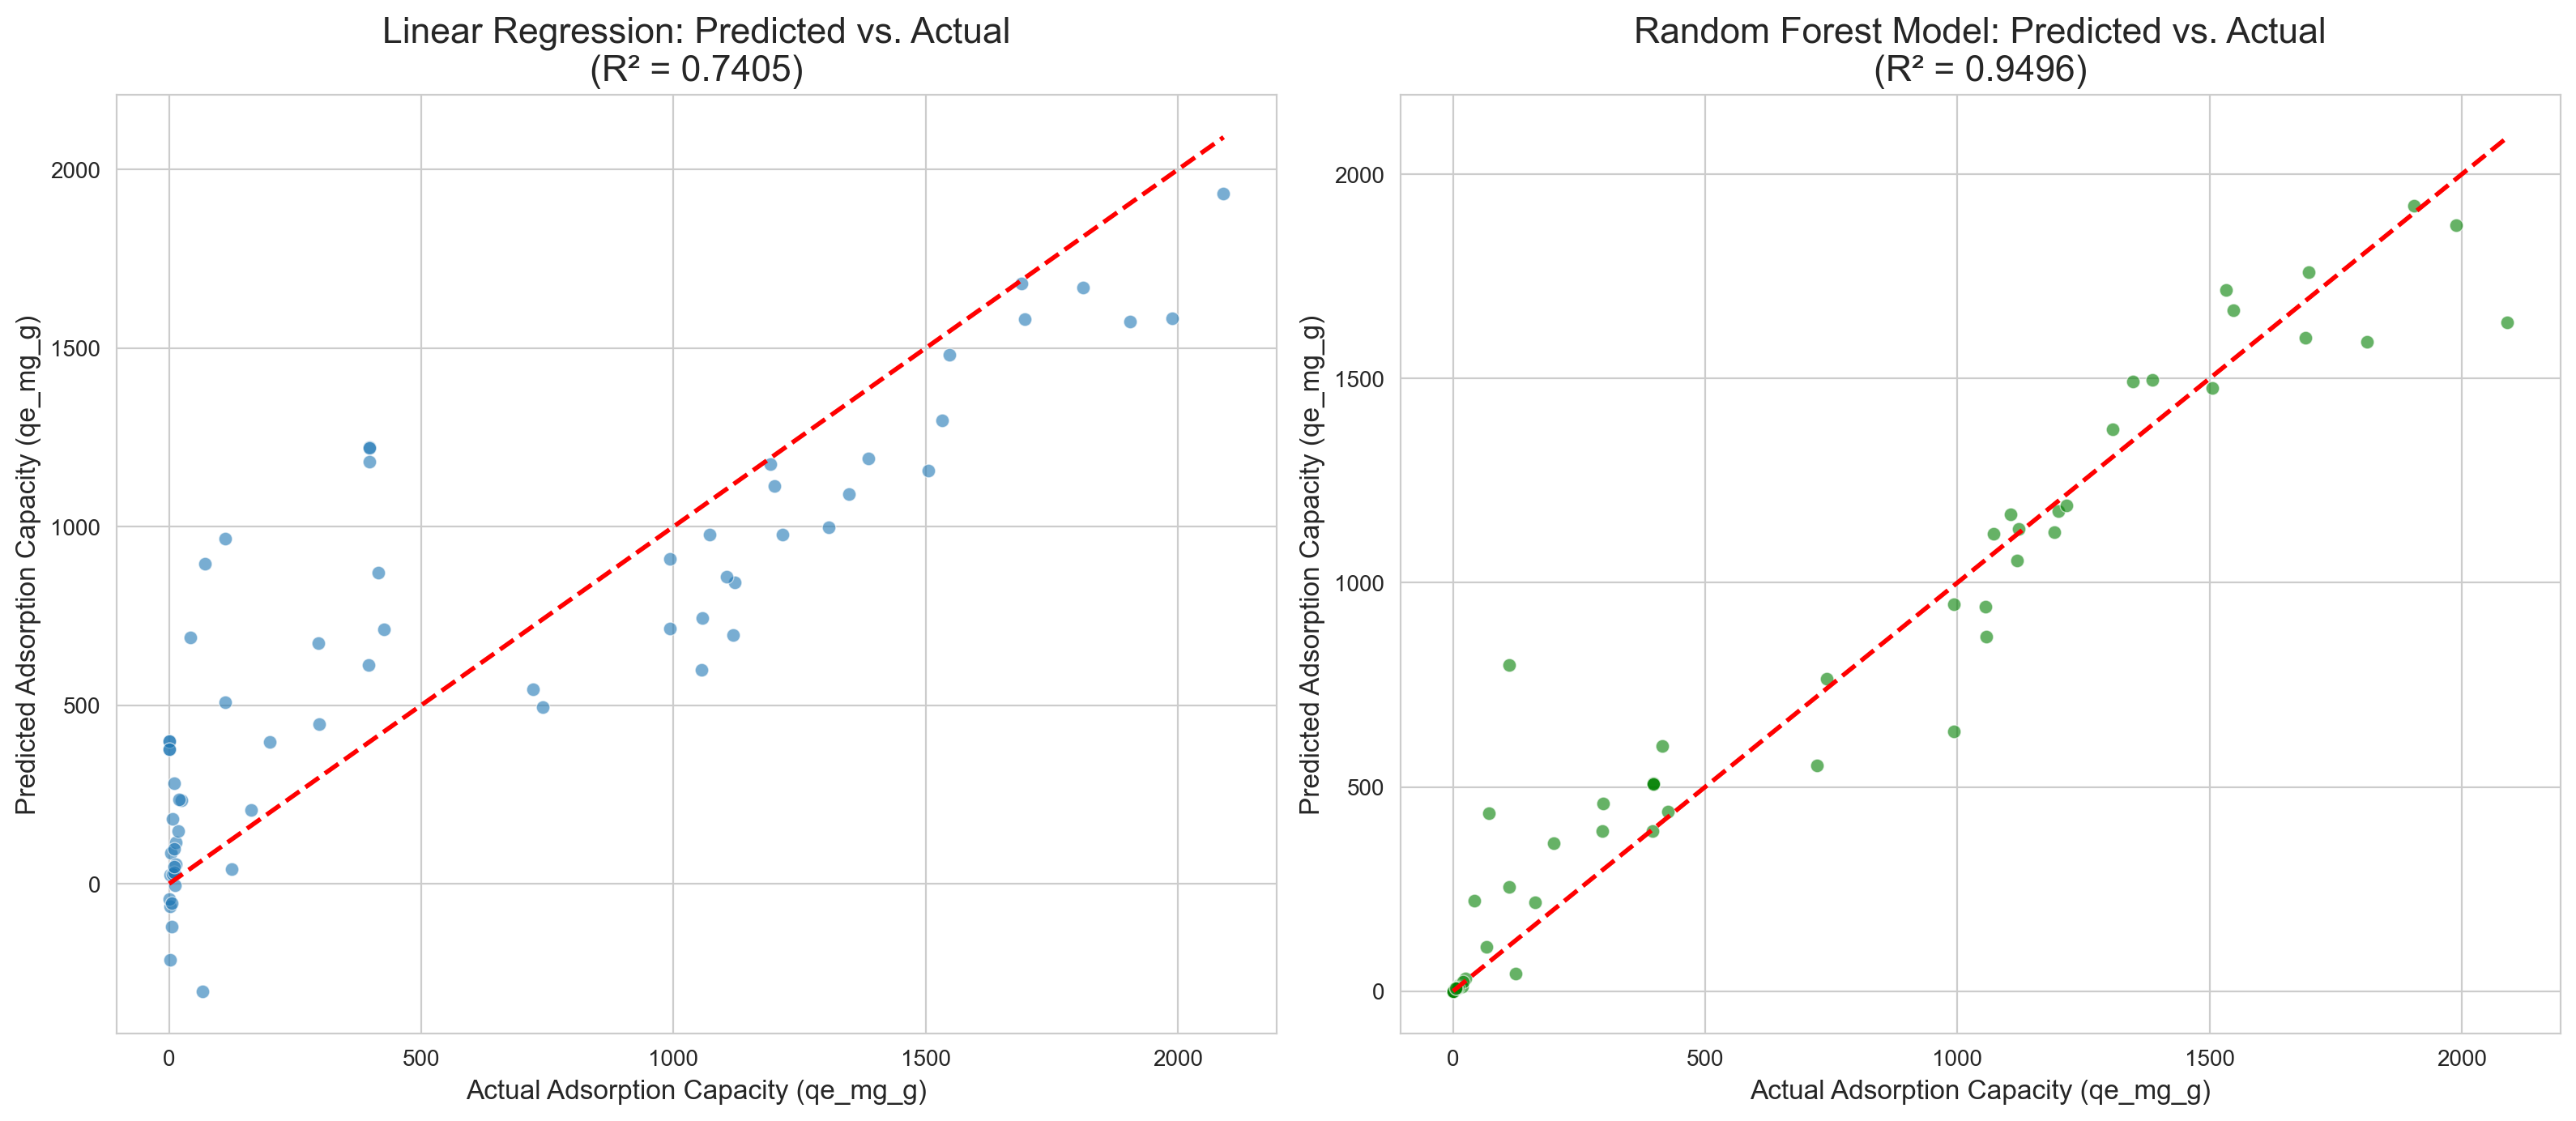

In [40]:
# --- Create a figure with two subplots side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.set_style("whitegrid")

# --- Plot 1: Linear Regression (Baseline Model) ---
# Fix: Specify axes[0] instead of axes for the first subplot
sns.scatterplot(x=y_test, y=y_pred_lr, ax=axes[0], alpha=0.6)
axes[0].set_title(f'Linear Regression: Predicted vs. Actual\n(R² = {r2_lr:.4f})', fontsize=16)
axes[0].set_xlabel('Actual Adsorption Capacity (qe_mg_g)', fontsize=12)
axes[0].set_ylabel('Predicted Adsorption Capacity (qe_mg_g)', fontsize=12)

# Add the "perfect prediction" line
max_val = max(y_test.max(), y_pred_lr.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2) # Dashed red line

# --- Plot 2: Random Forest ---
sns.scatterplot(x=y_test, y=y_pred_rf, ax=axes[1], alpha=0.6, color='green')
axes[1].set_title(f'Random Forest Model: Predicted vs. Actual\n(R² = {r2_rf:.4f})', fontsize=16)
axes[1].set_xlabel('Actual Adsorption Capacity (qe_mg_g)', fontsize=12)
axes[1].set_ylabel('Predicted Adsorption Capacity (qe_mg_g)', fontsize=12)

# Add the "perfect prediction" line
max_val = max(y_test.max(), y_pred_rf.max())
axes[1].plot([0, max_val], [0, max_val], 'r--', lw=2) # Dashed red line



# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plot.png', dpi=500)  


plt.tight_layout()
plt.show()

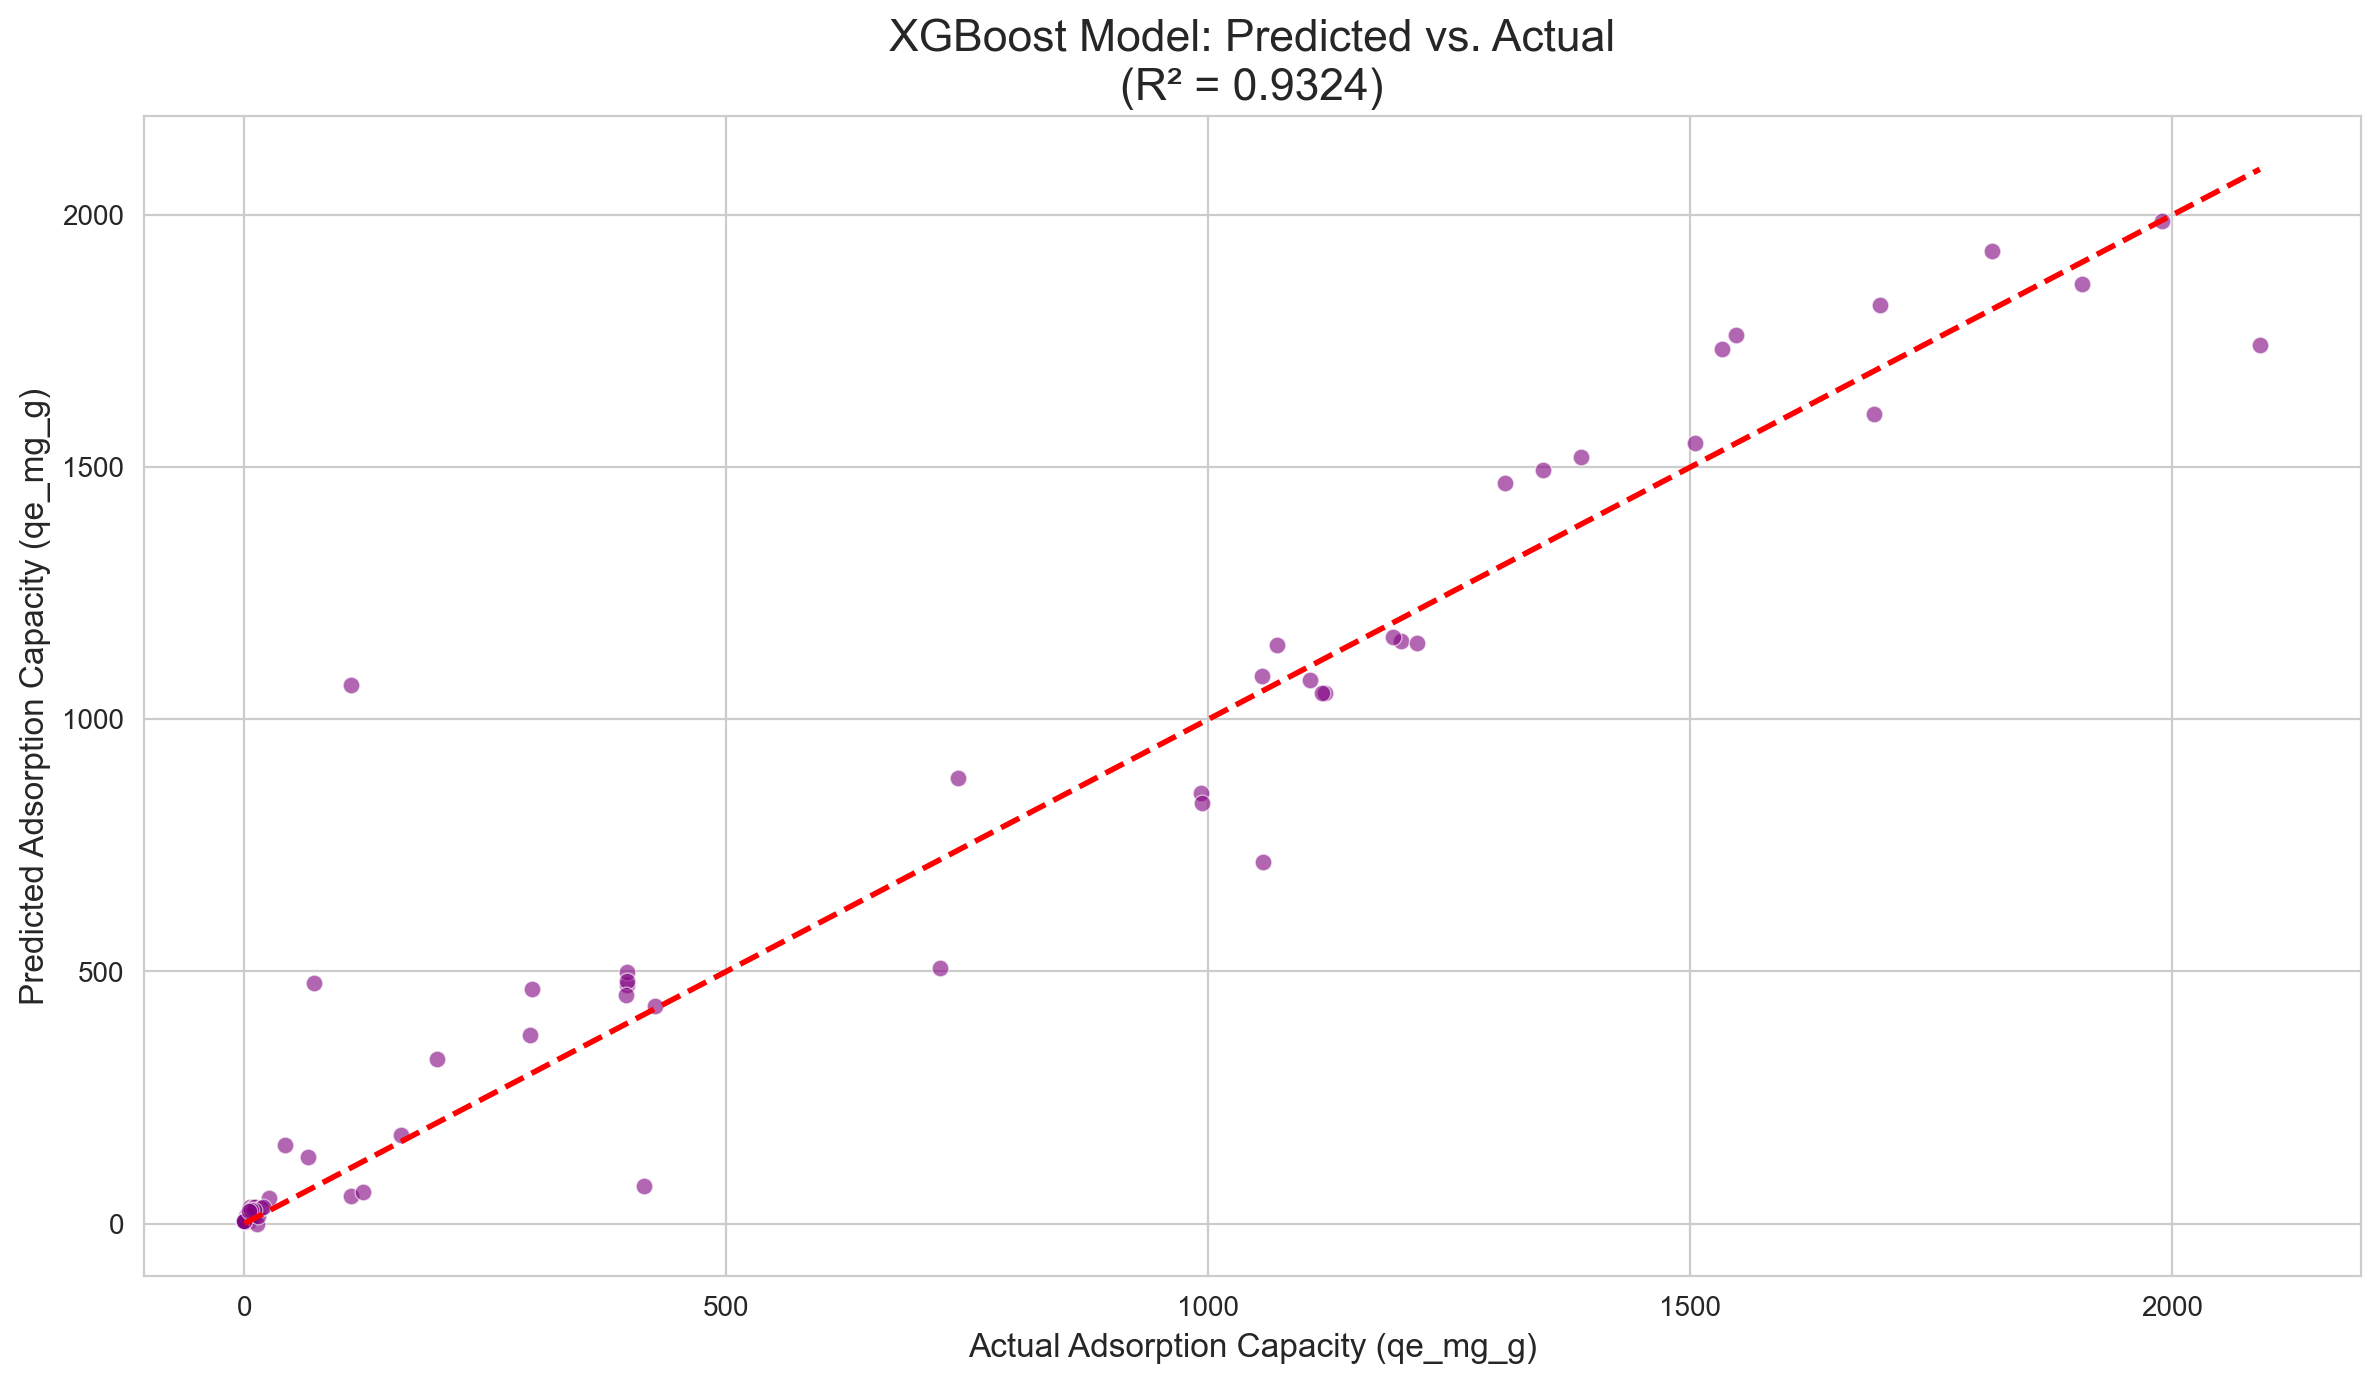

In [41]:
plt.figure(figsize=(12, 7))

# --- Plot 3: XGBoost ---
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6, color='purple')
plt.title(f'XGBoost Model: Predicted vs. Actual\n(R² = {r2_xgb:.4f})', fontsize=16)
plt.xlabel('Actual Adsorption Capacity (qe_mg_g)', fontsize=12)
plt.ylabel('Predicted Adsorption Capacity (qe_mg_g)', fontsize=12)

# Add the "perfect prediction" line
max_val = max(y_test.max(), y_pred_xgb.max())
plt.plot([0, max_val], [0, max_val], 'r--', lw=2) # Dashed red line

# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plot.png', dpi=300) 


plt.tight_layout()
plt.show()

## Residual Plot

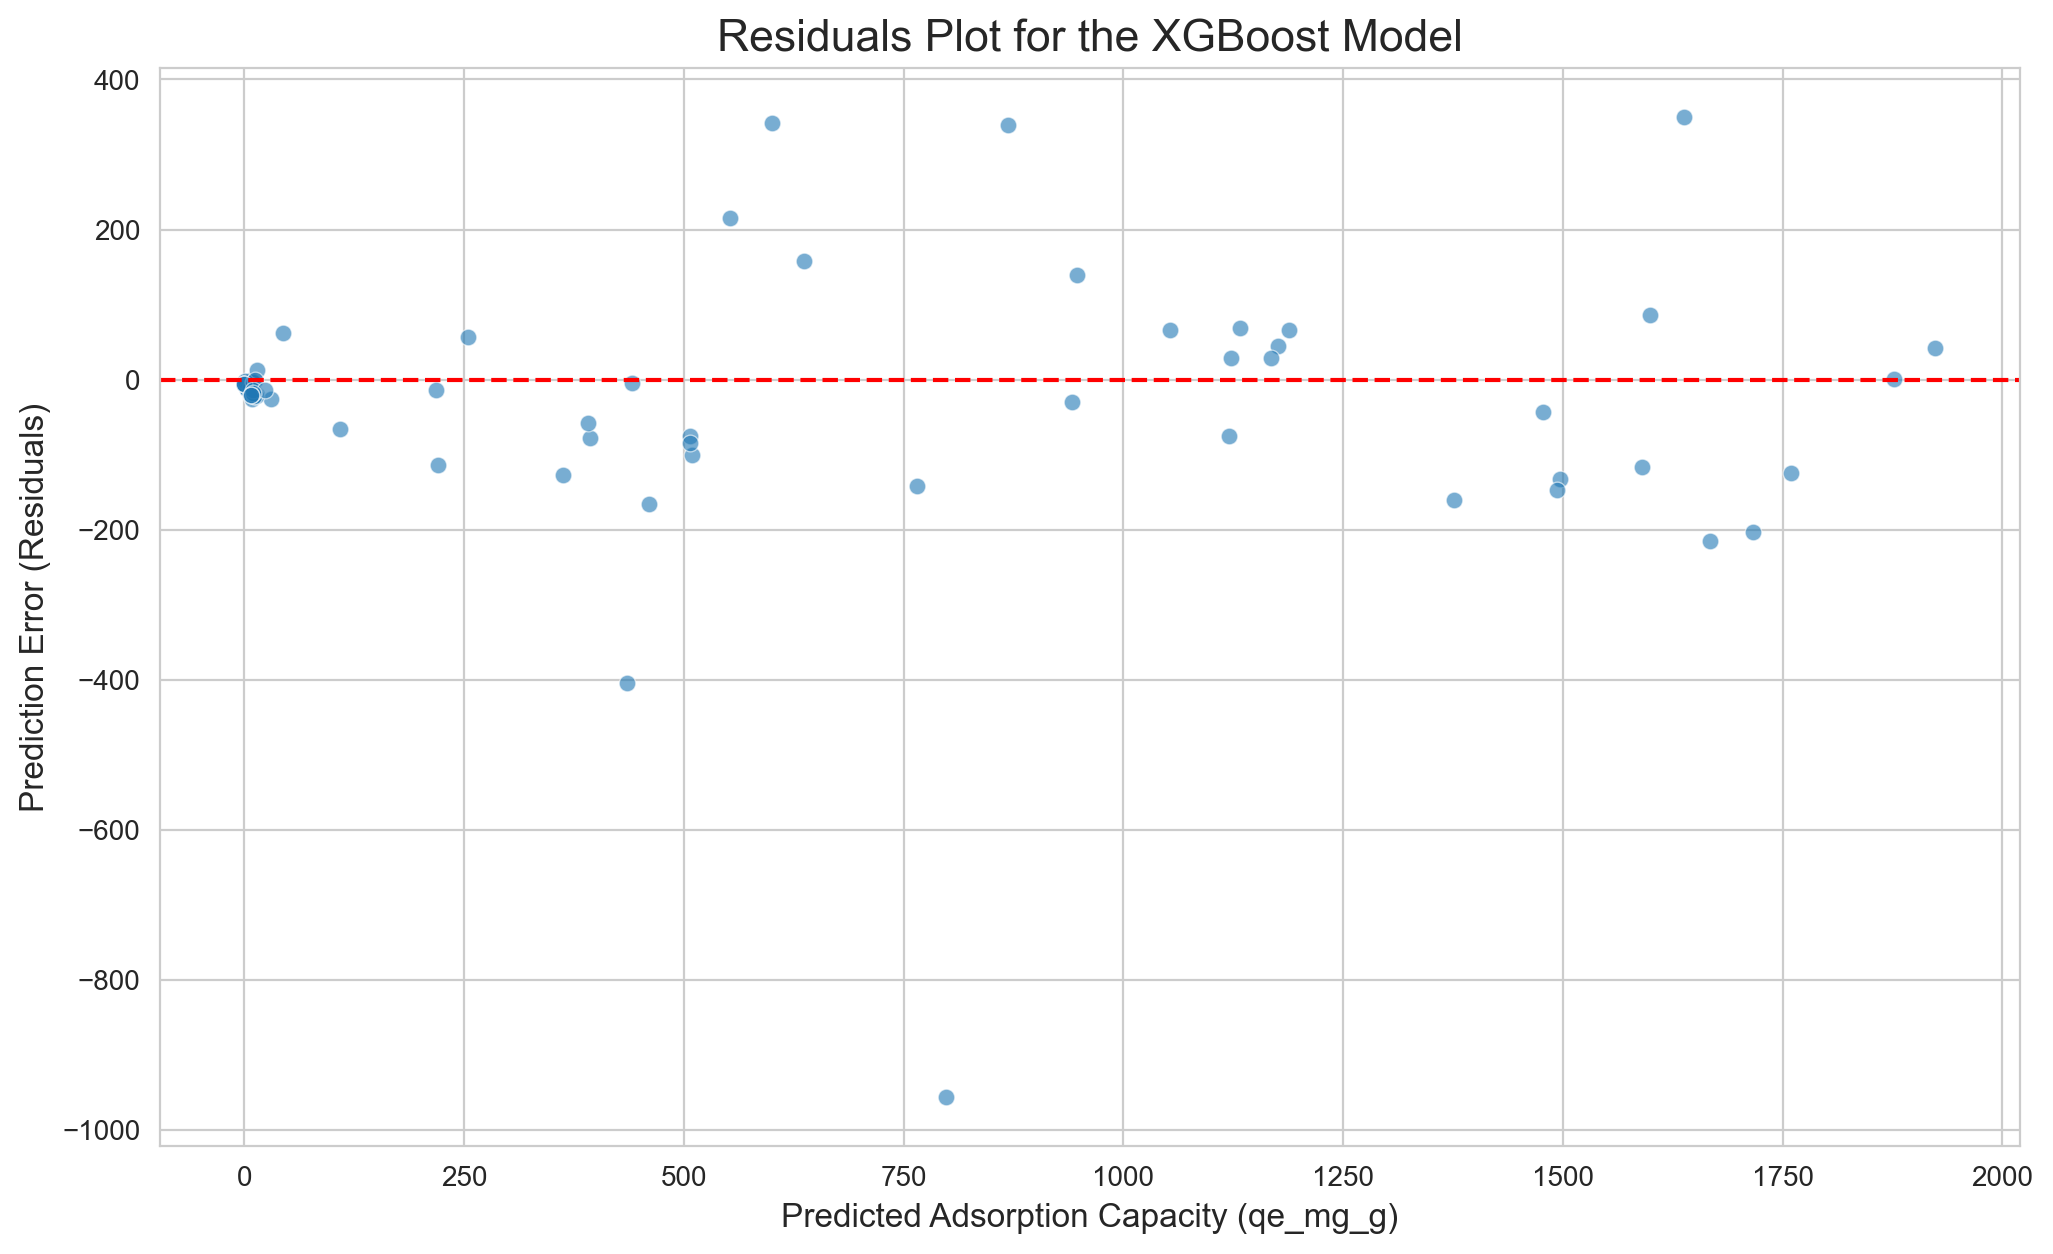

In [42]:


# --- Calculate the residuals ---
residuals = y_test - y_pred_xgb

# --- Create the Residuals Plot ---
plt.figure(figsize=(12, 7))
sns.scatterplot(x=y_pred_rf, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--') # Add a horizontal line at zero
plt.title('Residuals Plot for the XGBoost Model', fontsize=16)
plt.xlabel('Predicted Adsorption Capacity (qe_mg_g)', fontsize=12)
plt.ylabel('Prediction Error (Residuals)', fontsize=12)
plt.show()

# Explainable AI (XAI).

In [43]:
import shap

--- Creating SHAP Explainer ---
Calculating SHAP values for the training data... (This may take a minute)
SHAP values calculated.

--- Generating Global Feature Importance Plot ---


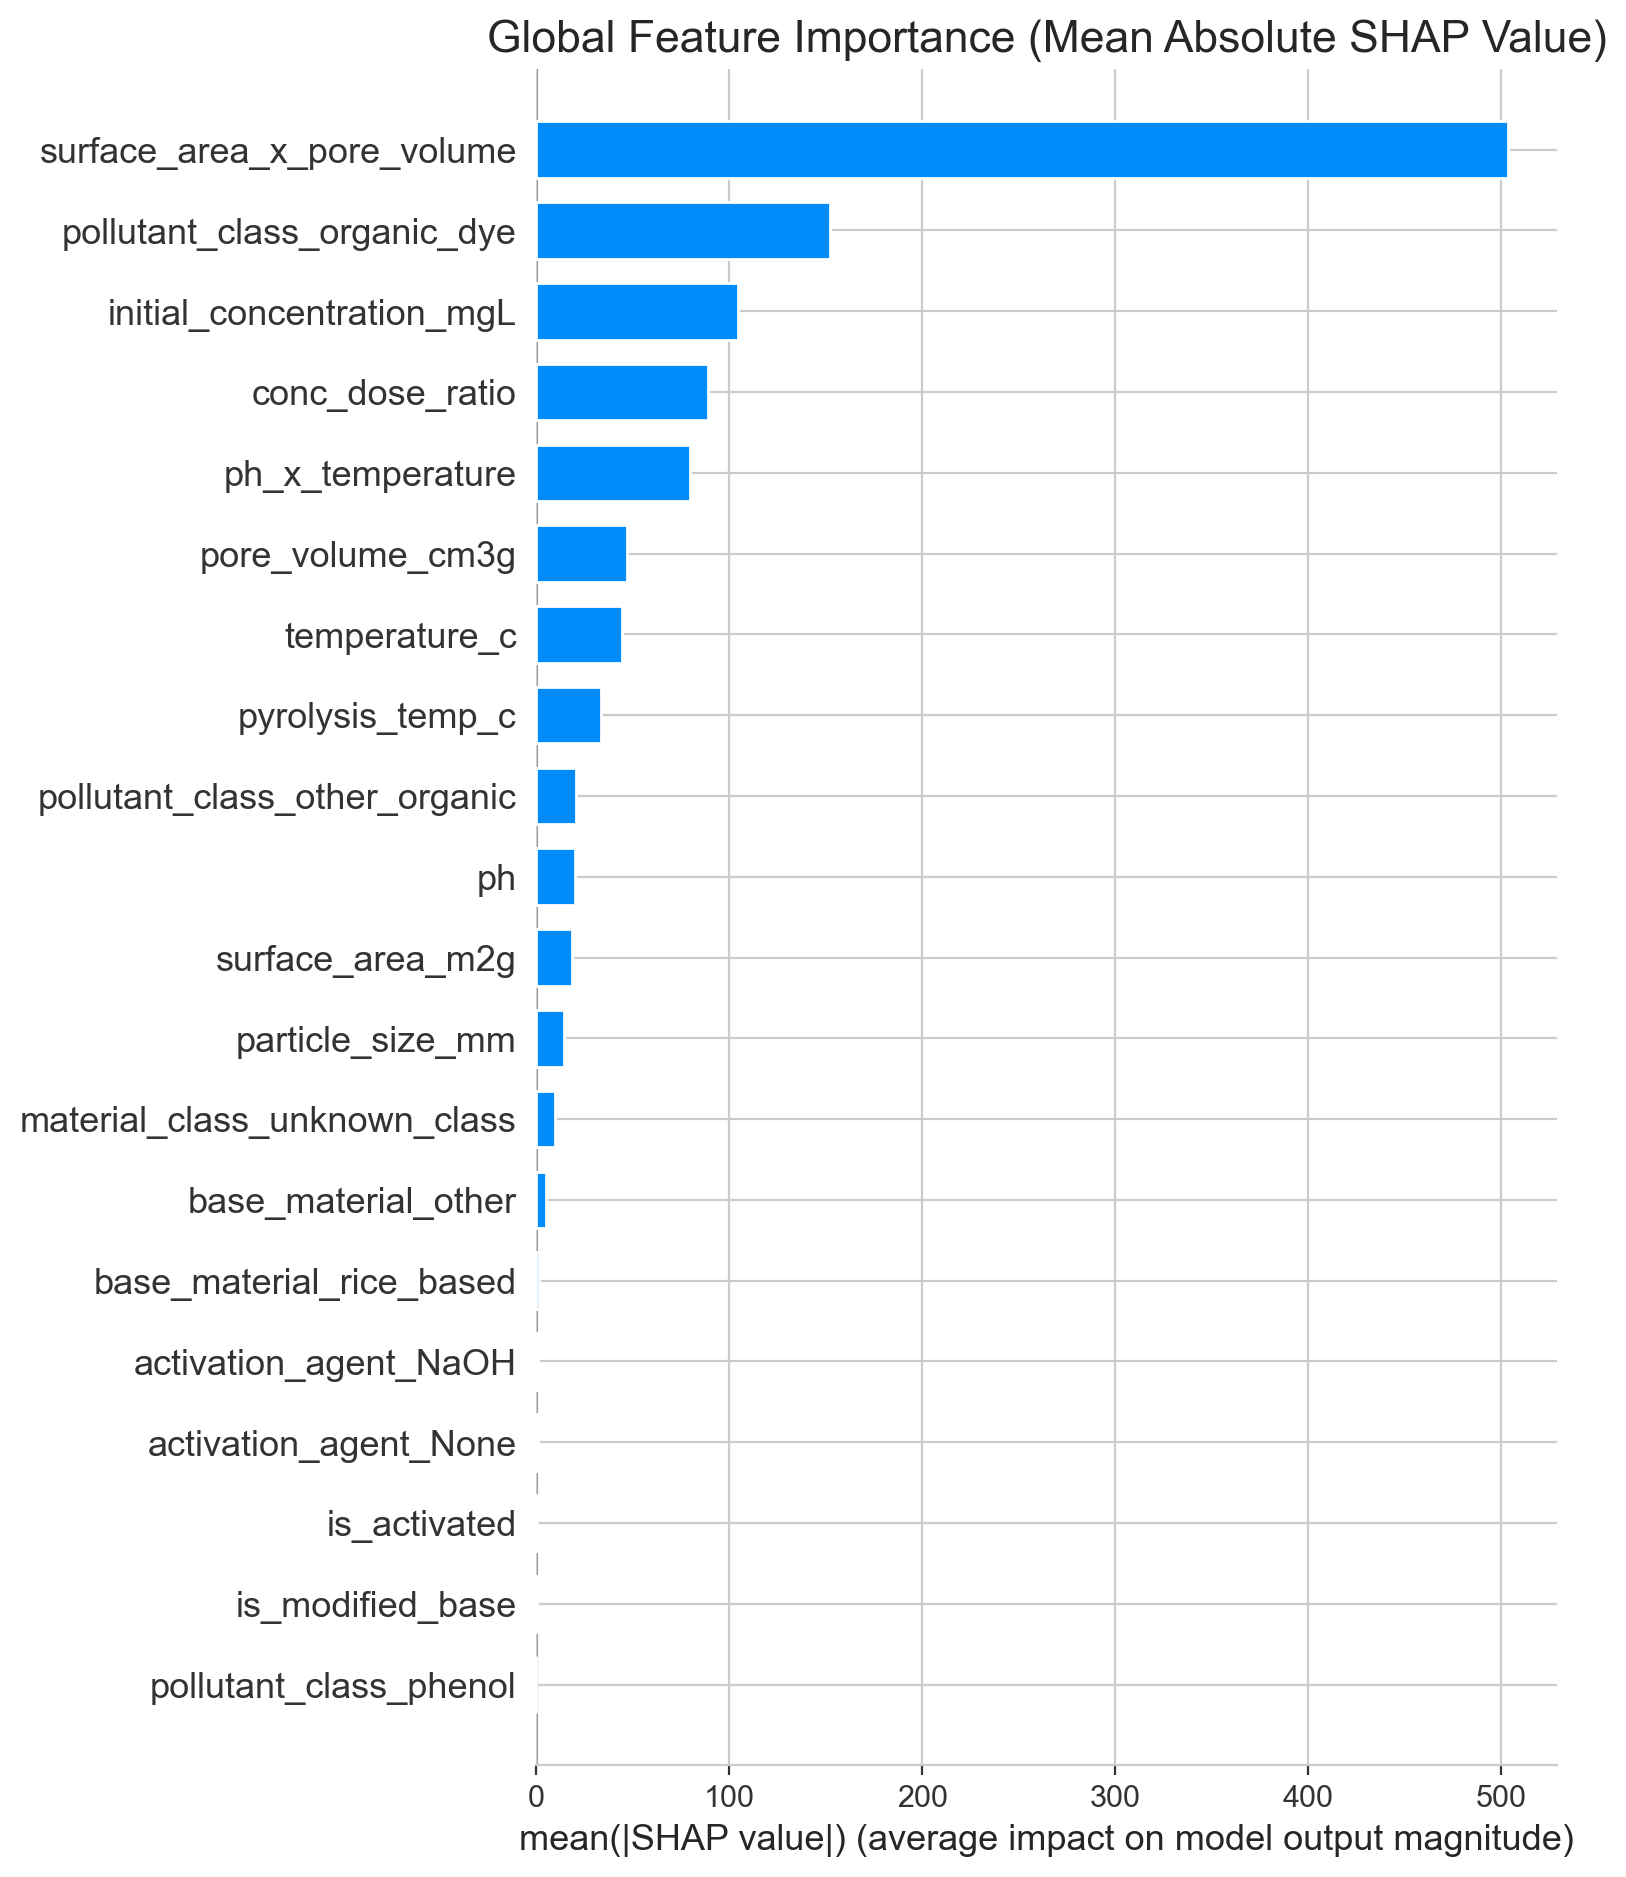

In [44]:
# --- Create a SHAP Explainer ---
# We use the TreeExplainer, which is optimized for tree-based models like XGBoost.
# We pass it our best-trained model and the training data it learned from.
print("--- Creating SHAP Explainer ---")
explainer = shap.TreeExplainer(best_model)

# --- Calculate SHAP Values ---
print("Calculating SHAP values for the training data... (This may take a minute)")
shap_values = explainer.shap_values(X_train)
print("SHAP values calculated.\n")


# --- Generate Visualizations for Your Presentation ---

# VISUALIZATION 1: Global Feature Importance (Bar Plot)
print("--- Generating Global Feature Importance Plot ---")
plt.title('Global Feature Importance (Mean Absolute SHAP Value)', fontsize=16)
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)

# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plot6.png', dpi=500) 

plt.show()



## Beeswarm Plot


--- Generating Detailed Feature Impact Plot (Beeswarm) ---


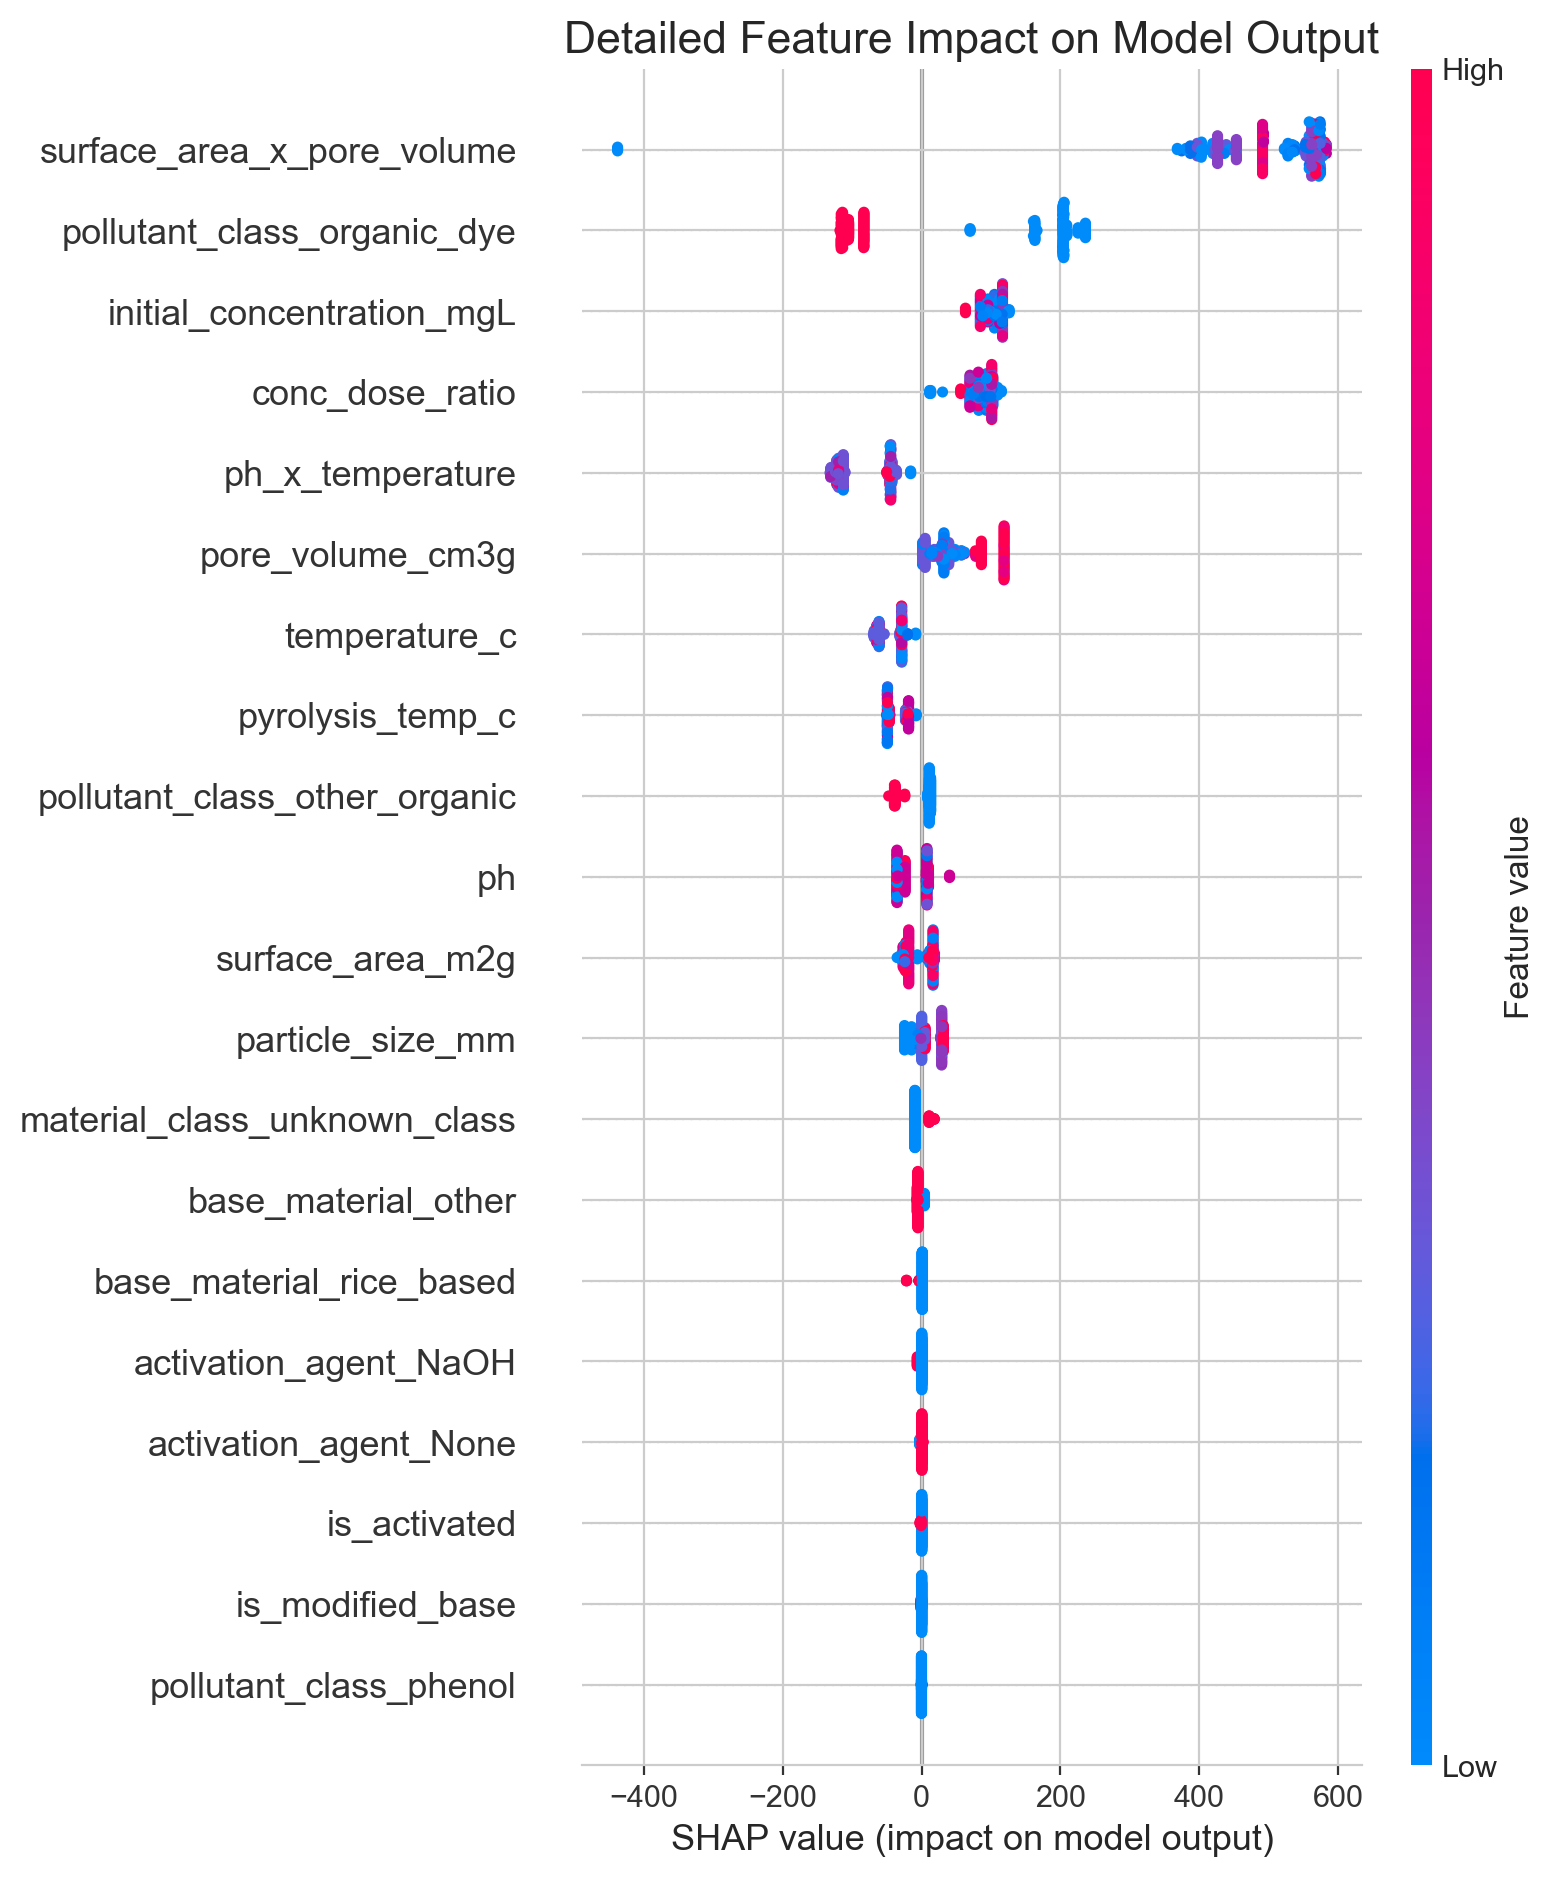

In [45]:
# VISUALIZATION 2: Detailed Feature Impact (Beeswarm Plot)
print("\n--- Generating Detailed Feature Impact Plot (Beeswarm) ---")
plt.title('Detailed Feature Impact on Model Output', fontsize=16)
shap.summary_plot(shap_values, X_train, show=False)

# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plot.png', dpi=500)  
plt.show()

## SHAP dependence plot

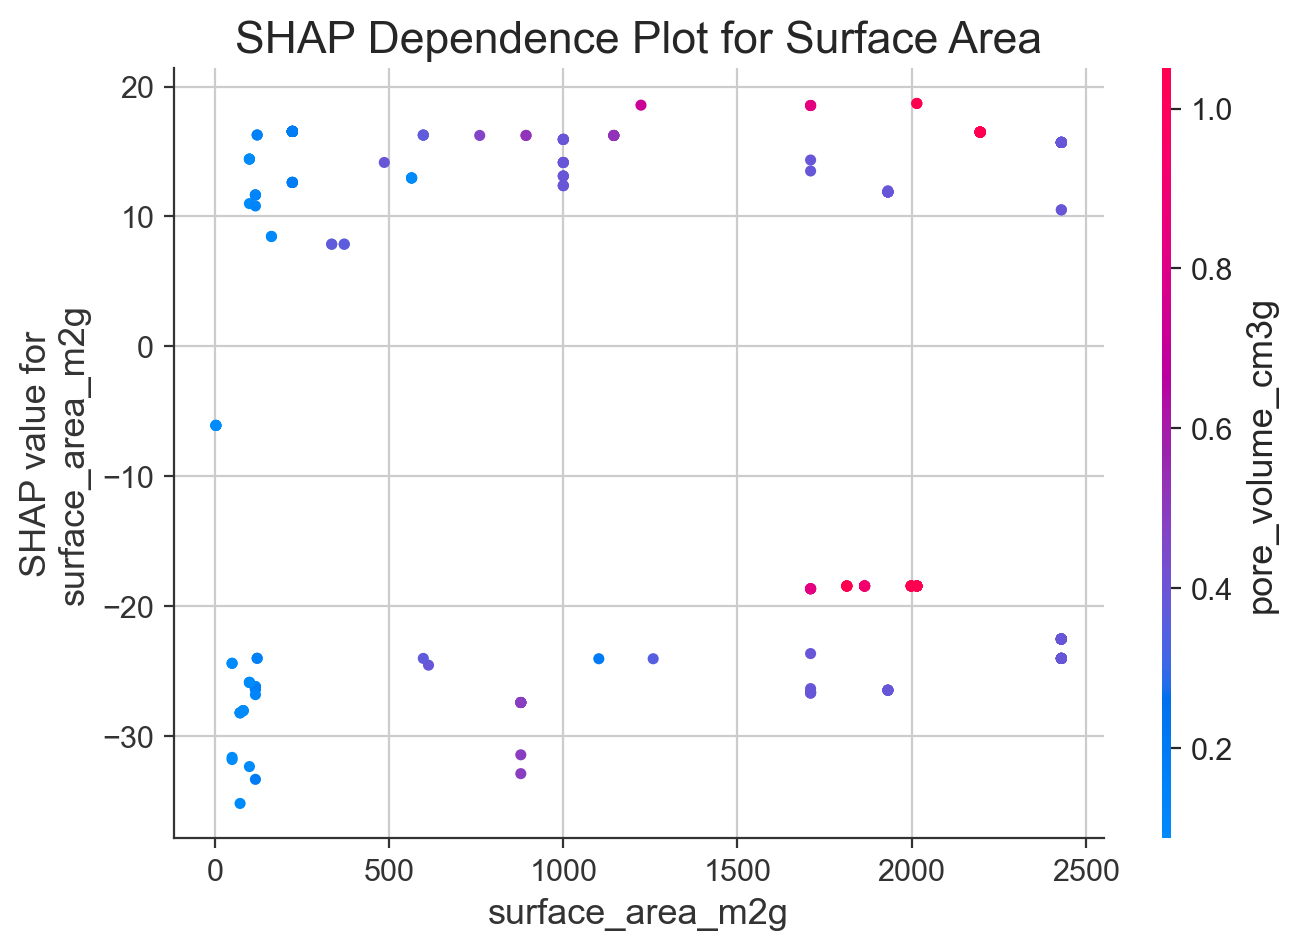

In [46]:
# This code assumes you have the 'explainer', 'shap_values', and 'X_train' variables from the XAI step

# --- Create the SHAP Dependence Plot ---
# We will look at the dependence of 'surface_area_m2g' and color it by 'pore_volume_cm3g'
shap.dependence_plot('surface_area_m2g',
                      shap_values,
                      X_train,
                      interaction_index='pore_volume_cm3g',
                      show=False)

plt.title('SHAP Dependence Plot for Surface Area', fontsize=16)

# %config InlineBackend.figure_format = 'retina'   # or 'retina' for crisp PNGs on HiDPI displays

# plt.savefig('my_plo.png', dpi=500) 
plt.show()